## Import

In [2]:
# Importing plotting and data manipulation tools
    # pandas
import pandas as pd
from pandas.plotting import table

    # matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from functools import reduce

    # numpy
import numpy as np
import numpy.linalg
from numpy.linalg import inv

    # scipy
import scipy
from scipy.signal import find_peaks

# Importing system tools
import glob
import os
from PIL import Image
from IPython import display
from IPython.display import Image

### Smoothing Import

In [2]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
#     r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
#     The Savitzky-Golay filter removes high frequency noise from data.
#     It has the advantage of preserving the original shape and
#     features of the signal better than other types of filtering
#     approaches, such as moving averages techniques.
#     Parameters
#     ----------
#     y : array_like, shape (N,)
#         the values of the time history of the signal.
#     window_size : int
#         the length of the window. Must be an odd integer number.
#     order : int
#         the order of the polynomial used in the filtering.
#         Must be less then `window_size` - 1.
#     deriv: int
#         the order of the derivative to compute (default = 0 means only smoothing)
#     Returns
#     -------
#     ys : ndarray, shape (N)
#         the smoothed signal (or it's n-th derivative).
#     Notes
#     -----
#     The Savitzky-Golay is a type of low-pass filter, particularly
#     suited for smoothing noisy data. The main idea behind this
#     approach is to make for each point a least-square fit with a
#     polynomial of high order over a odd-sized window centered at
#     the point.
#     Examples
#     --------
#     t = np.linspace(-4, 4, 500)
#     y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
#     ysg = savitzky_golay(y, window_size=31, order=4)
#     import matplotlib.pyplot as plt
#     plt.plot(t, y, label='Noisy signal')
#     plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
#     plt.plot(t, ysg, 'r', label='Filtered signal')
#     plt.legend()
#     plt.show()
#     References
#     ----------
#     .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
#        Data by Simplified Least Squares Procedures. Analytical
#        Chemistry, 1964, 36 (8), pp 1627-1639.
#     .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
#        W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
#        Cambridge University Press ISBN-13: 9780521880688
#     """
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

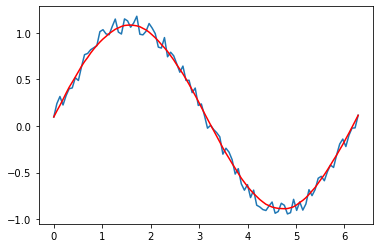

<Figure size 432x288 with 0 Axes>

In [3]:
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
yhat = savitzky_golay(y, 51, 3) # window size 51, polynomial order 3

plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.figure()
plt.show()

In [4]:
import nbformat as nbf
# from glob import glob

import uuid
def get_cell_id(id_length=8):
    return uuid.uuid4().hex[:id_length]

# your notebook name/keyword
nb_name = 'my_notebook'
notebooks = list(filter(lambda x: nb_name in x, glob.glob("./*.ipynb", recursive=True)))

# iterate over notebooks
for ipath in sorted(notebooks):
    # load notebook
    ntbk = nbf.read(ipath, nbf.NO_CONVERT)
    
    cell_ids = []
    for cell in ntbk.cells:
        cell_ids.append(cell['id'])

    # reset cell ids if there are duplicates
    if not len(cell_ids) == len(set(cell_ids)): 
        for cell in ntbk.cells:
            cell['id'] = get_cell_id()

        nbf.write(ntbk, ipath)

## Converting files extentions

In [5]:
# filenames = glob.glob('distance_12/*/bestsqs.out')

# for file in filenames:
#     base = os.path.splitext(file)[0]
#     os.rename(file, base + ".txt")

## Functions

### Function to convert the bestsqs coordinates into Crystal coordinates

Lattice parameters in crystal are taken by running a fast supercell calculation
and using as a supercell the lattice vectors of ATAT

for example, for -2=8 (distance equals to 8):

        x      y      z  atom
    0   3.912  0.000  0.000  None
    1   0.000  3.912  0.000  None
    2   0.000  0.000  3.912  None
    3   0.000  1.000  2.000  None
    4   1.000  0.000  0.000  None
    5   0.000  3.000 -2.000  None


    PbTiO3_P4mm
    CRYSTAL
    0 0 0
    221
    3.912
    3
    282  0.000000000000E+00  0.000000000000E+00  0.000000000000E+00
    222  5.000000000000E-01  5.000000000000E-01  5.000000000000E-01
    8    5.000000000000E-01  5.000000000000E-01  0.000000000000E+00
    SUPERCELL
    0. 1. 2.
    1. 0. 0.
    0. 3. -2.
    TESTGEOM
    OPTGEOM
    TOLDEG
    0.00003
    TOLDEX
    0.00012
    TOLDEE
    10
    END
    END
    282 4
    HAYWLC

In [20]:
def find_coord (key, dictionary_name):
    """
    Function that takes the HZO bestsqs.out data and transforms the coordonates of Zr into primitve coordonates 
    to be read into Crystal, meaning to compare with the Crystal Supercell.
    key : string, crystal phase with or without space group, i. e. "cubic", "monoclinic11"
    dictionary_name : dict, dictionary used to assemble all bestsqs.txt 
    """
    
    # find the index of the all Zr and put it in a list
    liste_index_Zr = dictionary_name[key].index[dictionary_name[key]['atom'] == 'Zr'].tolist()
    print(" the index of Zr positions are: ", liste_index_Zr, "\n")
    
    # creates empty dict to put Zr ATAT coordonates
    d_Zr_coord = {}
    print("Zr ATAT coordonates are: \n")
    for count, value in enumerate(liste_index_Zr):
        Zr = np.array(dictionary_name[key][['x','y','z']].iloc[liste_index_Zr[count]]).reshape(1,3)
        print("Zr"+str(count+1), Zr)
        d_Zr_coord["Zr"+str(count+1)] = Zr
    
    # extracts the matrix lattice vectors from bestsqs dataframe
    matrix_lat_vec = dictionary_name[key].iloc[3:6, 0:-1]
    print('\nMATRIX LAT VECTORS = \n', matrix_lat_vec, "\n")
    
    # inverses the matrix lattice vectors
    inverse_mat = np.linalg.inv(matrix_lat_vec)
    print('INVERSE MATRIX LAT VECTORS = \n', inverse_mat, "\n")
    
    # creates empty dict to put the result from matrix dot multiplication inside
    d_mat_prod_Zr = {}
    print("Zr converted coordinates are: \n")
    # iterates over the ATAT Zr coordinates
    for key in d_Zr_coord.keys():
        # multiplies by the inverse matrix to convert
        mat_prod_Zr = np.round(np.matmul(d_Zr_coord[key], inverse_mat), 3)
        print("mat_prod_"+str(key), mat_prod_Zr)
        # saves results to dict
        d_mat_prod_Zr["mat_prod_"+str(key)] = mat_prod_Zr

    print("\n")
    
    # the Zr coordinates can be shift from -1, lets iterate and obtain this second kind of coordinate
    d_mat_prod_Zr_neg = {}
    for key in d_mat_prod_Zr.keys():
        # the coordinates can be shift from -1
        matrix_prod_neg1_Zr = np.round((d_mat_prod_Zr[key])-1, 3)
        print(key+str(-1), matrix_prod_neg1_Zr)
        # saves result to dict
        d_mat_prod_Zr_neg[key+str(-1)] = matrix_prod_neg1_Zr
    
    return d_mat_prod_Zr, d_mat_prod_Zr_neg



In [21]:
def compare (ATAT_Crystal_SC, mat_prod_Zr, mat_prod_Zr_neg):
    """
    Function that will compare the elements of the ndarray of all Zr positions inside ATAT result
    and compare these coordinate elements to the elements of the ATAT SC generated with Crystal
    """
    final_atom_numbers = []
    columns = [1, 2, 3]
    # iterates over the different Zr positions (1 to 6) for positive and negative (shifted by 1) values, inside the dictionaries
    for key, key_neg in zip(mat_prod_Zr.keys(), mat_prod_Zr_neg):
        liste_coord_Zr = []
        # iterates over the different coordinates (x, y, z) for each Zr position (positive or negative shift by 1)
        # iterates over the three columns of the Crystal coordinates
        for i, i_neg, col in zip(mat_prod_Zr[key][0,:], mat_prod_Zr_neg[key_neg][0,:], columns):
            print("\nvalue of Zr"+key[-1],  i)
            print("value of Zr"+key_neg[-3]+" neg", i_neg)
            print('The column being check (inside ATAT SC using Crystal) is ', col)
            # if you want to check the boolean results of the comparison between the position value and the one of the matrix
            # uncomment below
            # print("check for positive Zr"+key[-1], ATAT_Crystal_SC[:,col]==i)
            # print("check for negative Zr"+key_neg[-3]+" neg", ATAT_Crystal_SC[:,col]==i_neg)
            # find the element of the column that fullfils the condition of being the same as the Zr1 one
            condition = np.where( (ATAT_Crystal_SC[:,col]==i) | (ATAT_Crystal_SC[:,col]==i_neg) )
            # if you want more information about the condition results, uncomment below
            print("satisfied coordinates are ", condition)
            print("satisfied coordinates (only the index) are", condition[0])
            print("how many options", len(condition[0]))
            # appends the result to previously empty list, only if the condition if non-null
            if len(condition[0]) != 0:
                liste_coord_Zr.append(condition[0])
            else:
                continue
        print("end of iteration for Zr"+key[-1]+" final list of coordinate options are: ", liste_coord_Zr)
        # finds the common index between all the position options
        line_Zr = reduce(np.intersect1d, (liste_coord_Zr))
        # if you want more information about the final results, uncomment below
        # print("the coordinate line is ", line_Zr)
        # print("The Zr"+key[-1]+" coordinate is in line: ", line_Zr, ', atom number: ', ATAT_Crystal_SC[line_Zr, 0])
        # appends the atom number into an empty list
        final_atom_numbers.append(ATAT_Crystal_SC[line_Zr, 0])
    
    print("FINAL", final_atom_numbers)
    return final_atom_numbers

In [22]:
# TO EDIT STILL, NOT GOOD FOR HZO

def launch_conversion (ATAT_Crystal_SC, distance, dictionary_name):
    """
    Function that combines find_coord() and compare().
    Takes the distance number and puts inside variables in functions find_coord() and compare().
    ATAT_Crystal_SC : ndarray matrix, generated with Crystal by using the matrix lattice vectors of ATAT;
    distance : string, distance number inside dictionary, i. e. "8", "s10"
    dictionary_name : dict, dictionary used to assemble all bestsqs.txt, i .e. "d_bestsqs_tetra"
    """
    
    Zr1, Zr1_neg, Zr2, Zr2_neg = find_coord(str(distance), dictionary_name)

    compare(ATAT_Crystal_SC, Zr1, Zr1_neg, Zr2, Zr2_neg)

### Function for making .d12 to launch in Crystal with ATAT inputs

In [23]:
 def crystal_d12 (new_file, crystal_struc, space_group, file_rndstr, atoms_unit_cell, file_bestsqs, file_fin):
    """complex_text_to_df(beginning_text, end_text, column_names):
        - Description: 
        new_file : "distance_12/HZO_ATAT_monoclinic14/atat_HfO2_SC_test_mono14.d12"
        crystal_struc : "mono"
        space_group : "14" 
        file_rndstr : "distance_12/HZO_ATAT_monoclinic14/rndstr.in"
        atoms_unit_cell : "12"
        file_bestsqs : "distance_12/HZO_ATAT_monoclinic14/bestsqs.txt"
        file_fin : "distance_12/HZO_ATAT_monoclinic14/fin.d12"
    """   
    with open(new_file, 'a') as f:
        f.write(''.join("HfO2 "+crystal_struc+" sp "+space_group+"\nCRYSTAL\n0 0 1\n"+space_group+"\n"))
        with open(file_rndstr, 'r') as g:
            idx_lines = []
            for i, line in enumerate(g):
                idx_lines.append(i)
                if i == 0:
                    f.write(''.join(line))
                    f.write(''.join(atoms_unit_cell+"\n"))
                if "0.0 0.0 1.0" in line:
                    idx = i+1


        with open(file_rndstr, 'r') as g:
            for j, line2 in enumerate(g):
                if idx <= j < max(idx_lines)+1:
                        f.write(''.join(line2))
        f.write('\nSUPERCELL\n')         

        matrix = []
        with open(file_bestsqs, 'r') as k:
            # getting indexes and lines from the document
            for i, line in enumerate(k):
                # finding the beginning of the dataframe I want inside f (file being read)
                if i in [3, 4, 5]:
                    matrix.append(line)      
        f.write(''.join(matrix))

        with open(file_fin, 'r') as m:
            for i, line in enumerate(m):
                f.write(''.join(line))

## Crystal DFT Supercells coordinates for each space group
- carried in Topaze, folders named atat_HfO2_SC_test_XXXXX

In [3]:
crystal_coord_cubic = np.around( 
                            np.array([
                                [1,  -2.500000000000E-01, -3.333333333333E-01, -4.166666666667E-01],
                                [2, 0.000000000000E+00,  3.333333333333E-01, -3.333333333333E-01],
                                [3, 2.500000000000E-01,  0.000000000000E+00, -2.500000000000E-01],
                                [4, -5.000000000000E-01, -3.333333333333E-01, -1.666666666667E-01],
                                [5, -2.500000000000E-01,  3.333333333333E-01, -8.333333333333E-02],
                                [6, 0.000000000000E+00,  0.000000000000E+00,  0.000000000000E+00],
                                [7, 2.500000000000E-01, -3.333333333333E-01,  8.333333333333E-02],
                                [8, -5.000000000000E-01,  3.333333333333E-01,  1.666666666667E-01],
                                [9, -2.500000000000E-01,  0.000000000000E+00,  2.500000000000E-01],
                                [10, 0.000000000000E+00, -3.333333333333E-01,  3.333333333333E-01],
                                [11, 2.500000000000E-01,  3.333333333333E-01,  4.166666666667E-01],
                                [12, -5.000000000000E-01,  0.000000000000E+00,  5.000000000000E-01]
                            ]), 
                            decimals=3)

In [4]:
crystal_coord_cubic

array([[ 1.   , -0.25 , -0.333, -0.417],
       [ 2.   ,  0.   ,  0.333, -0.333],
       [ 3.   ,  0.25 ,  0.   , -0.25 ],
       [ 4.   , -0.5  , -0.333, -0.167],
       [ 5.   , -0.25 ,  0.333, -0.083],
       [ 6.   ,  0.   ,  0.   ,  0.   ],
       [ 7.   ,  0.25 , -0.333,  0.083],
       [ 8.   , -0.5  ,  0.333,  0.167],
       [ 9.   , -0.25 ,  0.   ,  0.25 ],
       [10.   ,  0.   , -0.333,  0.333],
       [11.   ,  0.25 ,  0.333,  0.417],
       [12.   , -0.5  ,  0.   ,  0.5  ]])

In [277]:
crystal_coord_tetra = np.around( 
                            np.array([
                                [1,    5.000000000000E-01,  5.000000000000E-01,  3.333333333333E-01 ],
                                [2,    0.000000000000E+00,  0.000000000000E+00, -3.333333333333E-01 ],
                                [3,    5.000000000000E-01,  5.000000000000E-01,  0.000000000000E+00 ],
                                [4,    0.000000000000E+00,  0.000000000000E+00,  3.333333333333E-01 ],
                                [5,    5.000000000000E-01,  5.000000000000E-01, -3.333333333333E-01 ],
                                [6,    0.000000000000E+00,  0.000000000000E+00,  0.000000000000E+00 ],
                                [7,    0.000000000000E+00,  5.000000000000E-01,  0.000000000000E+00 ],
                                [8,    5.000000000000E-01,  0.000000000000E+00,  3.333333333333E-01 ],
                                [9,    0.000000000000E+00,  5.000000000000E-01, -3.333333333333E-01],
                                [10,    5.000000000000E-01,  0.000000000000E+00,  0.000000000000E+00],
                                [11,    0.000000000000E+00,  5.000000000000E-01,  3.333333333333E-01],
                                [12,    5.000000000000E-01,  0.000000000000E+00, -3.333333333333E-01]
                            ]), 
                            decimals=3)

In [322]:
crystal_coord_tetra_2 = np.around( 
                            np.array([
                                [1,    -5.000000000000E-01, -5.000000000000E-01,  3.333333333333E-01 ],
                                [2,    0.000000000000E+00,  2.220446049250E-16, -3.333333333333E-01 ],
                                [3,    -5.000000000000E-01, -5.000000000000E-01,  0.000000000000E+00 ],
                                [4,    0.000000000000E+00,  0.000000000000E+00,  3.333333333333E-01 ],
                                [5,    -5.000000000000E-01, -5.000000000000E-01, -3.333333333333E-01 ],
                                [6,  -1.110223024625E-16,  2.220446049250E-16, 0.000000000000E+00   ],
                                [7,  0.000000000000E+00, -5.000000000000E-01,  0.000000000000E+00  ],
                                [8,  -5.000000000000E-01,  0.000000000000E+00,  3.333333333333E-01  ],
                                [9,   0.000000000000E+00, -5.000000000000E-01, -3.333333333333E-01 ],
                                [10,   -5.000000000000E-01,  0.000000000000E+00,  0.000000000000E+00 ],
                                [11,  -8.326672684689E-17, -5.000000000000E-01,  3.333333333333E-01  ],
                                [12,   -5.000000000000E-01,  2.498001805407E-16, -3.333333333333E-01 ]
                            ]), 
                            decimals=3)

In [278]:
crystal_coord_mono11 = np.around(
                            np.array([
                                [1,   1.036053529416E-01,  2.009843089400E-01, -7.319732352918E-02   ],
                                [2,   4.369386862750E-01, -2.990156910601E-01,  9.346934313748E-02   ],
                                [3,  -2.297279803917E-01,  2.009843089399E-01,  2.601360098042E-01   ],
                                [4,   1.036053529416E-01, -2.990156910600E-01,  4.268026764708E-01   ],
                                [5,   4.369386862750E-01,  2.009843089400E-01, -4.065306568625E-01   ],
                                [6,  -2.297279803917E-01, -2.990156910601E-01, -2.398639901958E-01   ],
                                [7,  -1.036053529416E-01, -2.009843089400E-01,  7.319732352918E-02   ],
                                [8,   2.297279803917E-01,  2.990156910600E-01,  2.398639901958E-01   ],
                                [9,  -4.369386862750E-01, -2.009843089400E-01,  4.065306568625E-01   ],
                                [10, -1.036053529416E-01,  2.990156910600E-01, -4.268026764708E-01   ],
                                [11,  2.297279803917E-01, -2.009843089400E-01, -2.601360098041E-01   ],
                                [12, -4.369386862750E-01,  2.990156910600E-01, -9.346934313748E-02   ]
                            ]), 
                            decimals=3)

In [279]:
crystal_coord_mono14 = np.around( 
                            np.array([
                                [1,   4.352341993760E-01,  4.130563747484E-02,  3.553520467135E-01   ],
                                [2,  -2.314324672907E-01,  4.130563747484E-02,  2.201871338017E-02   ],
                                [3,   1.019008660427E-01,  4.130563747484E-02, -3.113146199532E-01   ],
                                [4,  -4.352341993760E-01, -4.586943625252E-01,  1.446479532865E-01   ],
                                [5,  -1.019008660427E-01, -4.586943625252E-01, -1.886853800468E-01   ],
                                [6,   2.314324672907E-01, -4.586943625252E-01,  4.779812866198E-01   ],
                                [7,  -1.019008660427E-01, -4.130563747484E-02,  3.113146199532E-01   ],
                                [8,   2.314324672907E-01, -4.130563747484E-02, -2.201871338017E-02   ],
                                [9,  -4.352341993760E-01, -4.130563747484E-02, -3.553520467135E-01   ],
                                [10, -2.314324672907E-01,  4.586943625252E-01, -4.779812866198E-01   ],
                                [11,  1.019008660427E-01,  4.586943625252E-01,  1.886853800468E-01   ],
                                [12,  4.352341993760E-01,  4.586943625252E-01, -1.446479532865E-01   ]
                            ]), 
                            decimals=3)

In [280]:
crystal_coord_ortho29 = np.around( 
                            np.array([
                                [1,   3.289247124117E-01,  4.850016329367E-01, -4.527219509033E-01   ],
                                [2,  -3.377419542550E-01, -1.816650337300E-01,  2.139447157634E-01   ],
                                [3,  -4.408620921630E-03,  1.516682996034E-01, -1.193886175700E-01   ],
                                [4,  -4.939876970672E-01,  9.752985939104E-02, -1.298095414244E-01   ],
                                [5,  -1.606543637338E-01,  4.308631927244E-01, -4.631428747578E-01   ],
                                [6,   1.726789695995E-01, -2.358034739423E-01, 2.035237919089E-01    ],
                                [7,  -4.828888328994E-01, -3.913712764412E-01, -1.409084055922E-01   ],
                                [8,  -1.495554995660E-01, -5.803794310783E-02, -4.742417389256E-01   ],
                                [9,   1.837778337673E-01,  2.752953902255E-01,  1.924249277411E-01   ],
                                [10,  3.178258482439E-01, -2.609723123111E-02, -4.416230867355E-01   ],
                                [11, -3.488408184228E-01,  3.072361021022E-01,  2.250435799312E-01   ],
                                [12, -1.550748508943E-02, -3.594305645644E-01, -1.082897534022E-01   ]
                            ]), 
                            decimals=3)

In [306]:
crystal_coord_ortho29_24atoms = np.around( 
                            np.array([
                                [1, -2.113626083883E-01,  1.790829263550E-01,  8.756536989674E-02    ],
                                [2,  2.886373916117E-01, -3.209170736450E-01, -4.124346301033E-01    ],
                                [3,  3.375653698967E-01, -3.052856878634E-01,  3.863739161166E-02   ],
                                [4, -1.624346301033E-01,  1.947143121366E-01, -4.613626083883E-01    ],
                                [5, -1.790829263550E-01, -2.886373916117E-01, -4.447143121366E-01    ],
                                [6,  3.209170736450E-01,  2.113626083883E-01,  5.528568786335E-02   ],
                                [7,  3.052856878634E-01,  1.624346301033E-01, -4.290829263550E-01   ],
                                [8, -1.947143121366E-01, -3.375653698967E-01,  7.091707364505E-02   ],
                            ]), 
                            decimals=3)

In [ ]:
crystal_coord_ortho61 = np.around( 
                            np.array([
                                [1,     ],
                                [2,     ],
                                [3,     ],
                                [4,     ],
                                [5,     ],
                                [6,     ],
                                [7,     ],
                                [8,     ],
                                [9,     ],
                                [10,    ],
                                [11,    ],
                                [12,    ]
                            ]), 
                            decimals=3)

      1 T 272 HF   -2.884174682610E-01 -1.790568371241E-01  1.591789271230E-01
      2 T 272 HF    2.115825317390E-01  1.790568371241E-01  3.408210728770E-01
      3 T 272 HF    2.884174682610E-01 -3.209431628759E-01 -3.408210728770E-01
      4 T 272 HF   -2.115825317390E-01  3.209431628759E-01 -1.591789271230E-01
      5 F 272 HF    2.884174682610E-01  1.790568371241E-01 -1.591789271230E-01
      6 F 272 HF   -2.115825317390E-01 -1.790568371241E-01 -3.408210728770E-01
      7 F 272 HF   -2.884174682610E-01  3.209431628759E-01  3.408210728770E-01
      8 F 272 HF    2.115825317390E-01 -3.209431628759E-01  1.591789271230E-01
      9 T 272 HF    2.356881210770E-01  1.790568371241E-01 -1.536355257380E-01
     10 T 272 HF   -2.643118789230E-01 -1.790568371241E-01 -3.463644742620E-01
     11 T 272 HF   -2.356881210770E-01  3.209431628759E-01  3.463644742620E-01
     12 T 272 HF    2.643118789230E-01 -3.209431628759E-01  1.536355257380E-01
     13 F 272 HF   -2.356881210770E-01 -1.790568371241E-01  1.536355257380E-01
     14 F 272 HF    2.643118789230E-01  1.790568371241E-01  3.463644742620E-01
     15 F 272 HF    2.356881210770E-01 -3.209431628759E-01 -3.463644742620E-01
     16 F 272 HF   -2.643118789230E-01  3.209431628759E-01 -1.536355257380E-01
     17 T 272 HF    2.884174682610E-01 -4.258999485920E-01  1.536355257380E-01
     18 T 272 HF   -2.115825317390E-01  4.258999485920E-01  3.463644742620E-01
     19 T 272 HF   -2.884174682610E-01 -7.410005140800E-02 -3.463644742620E-01
     20 T 272 HF    2.115825317390E-01  7.410005140800E-02 -1.536355257380E-01
     21 F 272 HF   -2.884174682610E-01  4.258999485920E-01 -1.536355257380E-01
     22 F 272 HF    2.115825317390E-01 -4.258999485920E-01 -3.463644742620E-01
     23 F 272 HF    2.884174682610E-01  7.410005140800E-02  3.463644742620E-01
     24 F 272 HF   -2.115825317390E-01 -7.410005140800E-02  1.536355257380E-01
     25 T 272 HF   -2.356881210770E-01  4.258999485920E-01 -1.591789271230E-01
     26 T 272 HF    2.643118789230E-01 -4.258999485920E-01 -3.408210728770E-01
     27 T 272 HF    2.356881210770E-01  7.410005140800E-02  3.408210728770E-01
     28 T 272 HF   -2.643118789230E-01 -7.410005140800E-02  1.591789271230E-01
     29 F 272 HF    2.356881210770E-01 -4.258999485920E-01  1.591789271230E-01
     30 F 272 HF   -2.643118789230E-01  4.258999485920E-01  3.408210728770E-01
     31 F 272 HF   -2.356881210770E-01 -7.410005140800E-02 -3.408210728770E-01
     32 F 272 HF    2.643118789230E-01  7.410005140800E-02 -1.591789271230E-01

In [281]:
crystal_coord_ortho62 = np.around( 
                            np.array([
                                [1,  -4.541602684838E-01, -1.082073056053E-01,  2.979764814393E-01  ],
                                [2,   2.125063981828E-01, -1.082073056053E-01, -3.535685189407E-02  ],
                                [3,  -1.208269351505E-01, -1.082073056053E-01, -3.686901852274E-01  ],
                                [4,  -4.513112685864E-01,  3.917926943947E-01,  2.965519814905E-01  ],
                                [5,   2.153553980803E-01,  3.917926943947E-01, -3.678135184280E-02  ],
                                [6,  -1.179779352530E-01,  3.917926943947E-01, -3.701146851761E-01  ],
                                [7,   1.179779352530E-01, -3.917926943947E-01,  3.701146851761E-01  ],
                                [8,  -2.153553980803E-01, -3.917926943947E-01, 3.678135184280E-02   ],
                                [9,   4.513112685864E-01, -3.917926943947E-01, -2.965519814905E-01  ],
                                [10,  1.208269351505E-01,  1.082073056053E-01, 3.686901852274E-01   ],
                                [11, -2.125063981828E-01,  1.082073056053E-01,  3.535685189407E-02  ],
                                [12,  4.541602684838E-01,  1.082073056053E-01, -2.979764814393E-01  ]
                            ]), 
                            decimals=3)

In [282]:
crystal_coord_triclinic = np.around( 
                            np.array([
                                  [1,  2.496040387174E-01,  1.250019520801E-01, -4.176878154057E-02 ],
                                  [2, -2.503959612827E-01, -3.749980479199E-01, -4.176878154057E-02 ],
                                  [3,  2.496040387174E-01,  1.250019520802E-01,  2.915645517928E-01 ],
                                  [4, -2.503959612827E-01, -3.749980479198E-01,  2.915645517928E-01 ],
                                  [5,  2.496040387174E-01, 1.250019520802E-01, -3.751021148739E-01  ],
                                  [6, -2.503959612827E-01, -3.749980479199E-01, -3.751021148739E-01 ],
                                  [7, -2.496040387174E-01, -1.250019520802E-01, 4.176878154057E-02  ],
                                  [8,  2.503959612827E-01,  3.749980479198E-01,  4.176878154057E-02 ],
                                  [9, -2.496040387174E-01, -1.250019520802E-01, 3.751021148739E-01  ],
                                  [10,  2.503959612827E-01,  3.749980479198E-01,  3.751021148739E-01],
                                  [11, -2.496040387174E-01, -1.250019520802E-01, -2.915645517928E-01],
                                  [12,  2.503959612827E-01,  3.749980479199E-01, -2.915645517928E-01]
                            ]), 
                            decimals=3)



## 1. HZO ATAT : distance -2 = 12
With real lattice parameters 

### Saving the bestsqs.out into a dictionary with all -2 tested

In [4]:
filenames = glob.glob('distance_12/*/bestsqs.txt')
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
print(filenames)

['distance_12\\HZO_ATAT_cubic\\bestsqs.txt', 'distance_12\\HZO_ATAT_tetra\\bestsqs.txt', 'distance_12\\HZO_ATAT_triclinic\\bestsqs.txt', 'distance_12\\HZO_ATAT_tetra_2\\bestsqs.txt', 'distance_12\\HZO_ATAT_monoclinic11\\bestsqs.txt', 'distance_12\\HZO_ATAT_monoclinic14\\bestsqs.txt', 'distance_12\\HZO_ATAT_ortho29\\bestsqs.txt', 'distance_12\\HZO_ATAT_ortho61\\bestsqs.txt', 'distance_12\\HZO_ATAT_ortho62\\bestsqs.txt', 'distance_12\\HZO_ATAT_ortho29_24atoms\\bestsqs.txt']


In [5]:
d_bestsqs = {}
for file in filenames:
#     print(file[21:-12])
    df = pd.read_csv(file, delim_whitespace=True, names=['x', 'y', 'z', 'atom'], header=None, engine='python',index_col=False)
    d_bestsqs[file[21:-12]] = df
    
# print(d_bestsqs)

In [6]:
d_bestsqs.keys()

dict_keys(['cubic', 'tetra', 'triclinic', 'tetra_2', 'monoclinic11', 'monoclinic14', 'ortho29', 'ortho61', 'ortho62', 'ortho29_24atoms'])

In [7]:
d_bestsqs["ortho61"]

,x,y,z,atom
0,10.091800,0.000000,0.000000,None
1,0.000000,5.257900,0.000000,None
2,0.000000,0.000000,5.090500,None
3,0.000000,0.000000,-1.000000,None
4,0.000000,-1.000000,0.000000,None
5,-1.000000,0.000000,0.000000,None
6,-0.159179,-0.820943,-0.711583,Hf
7,-0.840821,-0.179057,-0.288417,Zr
8,-0.846364,-0.179057,-0.235688,Zr
9,-0.153636,-0.820943,-0.764312,Hf


## Number of atoms = 36
* common value for multiple phases, all multiple of 36 (3, 6 or 12 atoms per unit cell $\times$ 2 mixing atoms (Zr and Hf))

### HZO Cubic 225
OPTGEOM CRYSTAL 14/11
 - Zr1 
 - Zr2 
 - Zr3 
 - Zr4 
 - Zr5 
 - Zr6 
 

In [286]:
mat_prod_Zr, mat_prod_Zr_neg = find_coord("cubic", d_bestsqs)

compare(crystal_coord_cubic, mat_prod_Zr, mat_prod_Zr_neg)

 the index of Zr positions are:  [6, 8, 9, 13, 15, 17] 

Zr ATAT coordonates are: 

Zr1 [[ 1. -0. -1.]]
Zr2 [[3. 2. 0.]]
Zr3 [[ 1.  0. -0.]]
Zr4 [[2. 2. 0.]]
Zr5 [[ 2.  1. -1.]]
Zr6 [[2. 2. 1.]]

MATRIX LAT VECTORS = 
      x    y    z
3  1.0 -1.0  1.0
4  1.0 -0.0 -2.0
5  1.0  3.0  1.0 

INVERSE MATRIX LAT VECTORS = 
 [[ 0.5         0.33333333  0.16666667]
 [-0.25        0.          0.25      ]
 [ 0.25       -0.33333333  0.08333333]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.25  0.667 0.083]]
mat_prod_Zr2 [[1. 1. 1.]]
mat_prod_Zr3 [[0.5   0.333 0.167]]
mat_prod_Zr4 [[0.5   0.667 0.833]]
mat_prod_Zr5 [[0.5 1.  0.5]]
mat_prod_Zr6 [[0.75  0.333 0.917]]


mat_prod_Zr1-1 [[-0.75  -0.333 -0.917]]
mat_prod_Zr2-1 [[0. 0. 0.]]
mat_prod_Zr3-1 [[-0.5   -0.667 -0.833]]
mat_prod_Zr4-1 [[-0.5   -0.333 -0.167]]
mat_prod_Zr5-1 [[-0.5  0.  -0.5]]
mat_prod_Zr6-1 [[-0.25  -0.667 -0.083]]

value of Zr1 0.25
value of Zr1 neg -0.75
The column being check (inside ATAT SC using Crystal) is  1
check f

### HZO Tetra 137
OPTGEOM CRYSTAL 14/11 - did not work
 - Zr1 
 - Zr2 
 - Zr3 
 - Zr4 
 - Zr5 
 - Zr6 

In [302]:
# d_bestsqs["tetra"]

In [303]:
mat_prod_Zr,  mat_prod_Zr_neg = find_coord("tetra", d_bestsqs)

compare(ATAT_Crystal_SC = crystal_coord_tetra, 
        mat_prod_Zr = mat_prod_Zr, 
        mat_prod_Zr_neg = mat_prod_Zr_neg)

 the index of Zr positions are:  [6, 8, 10, 11, 13, 16] 

Zr ATAT coordonates are: 

Zr1 [[ 1. -0.  2.]]
Zr2 [[0. 0. 2.]]
Zr3 [[ 0. -0.  1.]]
Zr4 [[ 1. -0.  1.]]
Zr5 [[0.5 0.5 1.5]]
Zr6 [[ 0.5 -0.5  1.5]]

MATRIX LAT VECTORS = 
      x    y    z
3 -1.0  1.0  1.0
4 -1.0 -1.0  1.0
5  3.0 -0.0  0.0 

INVERSE MATRIX LAT VECTORS = 
 [[ 0.          0.          0.33333333]
 [ 0.5        -0.5        -0.        ]
 [ 0.5         0.5         0.33333333]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[1. 1. 1.]]
mat_prod_Zr2 [[1.    1.    0.667]]
mat_prod_Zr3 [[0.5   0.5   0.333]]
mat_prod_Zr4 [[0.5   0.5   0.667]]
mat_prod_Zr5 [[1.    0.5   0.667]]
mat_prod_Zr6 [[0.5   1.    0.667]]


mat_prod_Zr1-1 [[0. 0. 0.]]
mat_prod_Zr2-1 [[ 0.     0.    -0.333]]
mat_prod_Zr3-1 [[-0.5   -0.5   -0.667]]
mat_prod_Zr4-1 [[-0.5   -0.5   -0.333]]
mat_prod_Zr5-1 [[ 0.    -0.5   -0.333]]
mat_prod_Zr6-1 [[-0.5    0.    -0.333]]

value of Zr1 1.0
value of Zr1 neg 0.0
The column being check (inside ATAT SC using Cry

### HZO Tetra_2 137
coordinates from HfO2_TZVP_sp137_2-1594057.o, as I have an error with the other coord, lets try using this .out file


In [323]:
mat_prod_Zr,  mat_prod_Zr_neg = find_coord("tetra_2", d_bestsqs)

compare(ATAT_Crystal_SC = crystal_coord_tetra_2, 
        mat_prod_Zr = mat_prod_Zr, 
        mat_prod_Zr_neg = mat_prod_Zr_neg)

 the index of Zr positions are:  [6, 7, 10, 11, 13, 16] 

Zr ATAT coordonates are: 

Zr1 [[ 1. -0.  2.]]
Zr2 [[-1.  0.  2.]]
Zr3 [[ 0. -0.  1.]]
Zr4 [[1. 0. 1.]]
Zr5 [[-0.5 -0.5  1.5]]
Zr6 [[-0.5  0.5  1.5]]

MATRIX LAT VECTORS = 
      x    y    z
3 -1.0  1.0  1.0
4 -1.0 -1.0  1.0
5  3.0 -0.0  0.0 

INVERSE MATRIX LAT VECTORS = 
 [[ 0.          0.          0.33333333]
 [ 0.5        -0.5        -0.        ]
 [ 0.5         0.5         0.33333333]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[1. 1. 1.]]
mat_prod_Zr2 [[1.    1.    0.333]]
mat_prod_Zr3 [[0.5   0.5   0.333]]
mat_prod_Zr4 [[0.5   0.5   0.667]]
mat_prod_Zr5 [[0.5   1.    0.333]]
mat_prod_Zr6 [[1.    0.5   0.333]]


mat_prod_Zr1-1 [[0. 0. 0.]]
mat_prod_Zr2-1 [[ 0.     0.    -0.667]]
mat_prod_Zr3-1 [[-0.5   -0.5   -0.667]]
mat_prod_Zr4-1 [[-0.5   -0.5   -0.333]]
mat_prod_Zr5-1 [[-0.5    0.    -0.667]]
mat_prod_Zr6-1 [[ 0.    -0.5   -0.667]]

value of Zr1 1.0
value of Zr1 neg 0.0
The column being check (inside ATAT SC using 

### HZO Monoclinic 11
OPTGEOM CRYSTAL 14/11

In [288]:
mat_prod_Zr, mat_prod_Zr_neg = find_coord("monoclinic11", d_bestsqs)

compare(ATAT_Crystal_SC = crystal_coord_mono11, 
        mat_prod_Zr = mat_prod_Zr, 
        mat_prod_Zr_neg = mat_prod_Zr_neg)

 the index of Zr positions are:  [7, 8, 10, 11, 14, 15] 

Zr ATAT coordonates are: 

Zr1 [[-1.231392  0.25     -0.170576]]
Zr2 [[-1.231392 -1.75      0.829424]]
Zr3 [[-1.231392 -0.75      0.829424]]
Zr4 [[-1.231392  0.25      0.829424]]
Zr5 [[-1.768608  0.75      0.170576]]
Zr6 [[-1.768608 -1.25      1.170576]]

MATRIX LAT VECTORS = 
      x    y    z
3 -1.0  1.0  1.0
4 -1.0  0.0 -1.0
5 -1.0 -2.0  1.0 

INVERSE MATRIX LAT VECTORS = 
 [[-0.33333333 -0.5        -0.16666667]
 [ 0.33333333 -0.         -0.33333333]
 [ 0.33333333 -0.5         0.16666667]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.437 0.701 0.093]]
mat_prod_Zr2 [[0.104 0.201 0.927]]
mat_prod_Zr3 [[0.437 0.201 0.593]]
mat_prod_Zr4 [[0.77  0.201 0.26 ]]
mat_prod_Zr5 [[0.896 0.799 0.073]]
mat_prod_Zr6 [[0.563 0.299 0.907]]


mat_prod_Zr1-1 [[-0.563 -0.299 -0.907]]
mat_prod_Zr2-1 [[-0.896 -0.799 -0.073]]
mat_prod_Zr3-1 [[-0.563 -0.799 -0.407]]
mat_prod_Zr4-1 [[-0.23  -0.799 -0.74 ]]
mat_prod_Zr5-1 [[-0.104 -0.201 -0.927]

### HZO Monoclinic 14
OPTGEOM CRYSTAL 14/11

In [289]:
mat_prod_Zr, mat_prod_Zr_neg = find_coord("monoclinic14", d_bestsqs)

compare(ATAT_Crystal_SC = crystal_coord_mono14, 
        mat_prod_Zr = mat_prod_Zr, 
        mat_prod_Zr_neg = mat_prod_Zr_neg)

 the index of Zr positions are:  [6, 7, 8, 10, 13, 17] 

Zr ATAT coordonates are: 

Zr1 [[ 0.27547   0.041306 -0.790586]]
Zr2 [[ 1.27547   0.041306 -0.790586]]
Zr3 [[-0.72453   0.041306 -0.790586]]
Zr4 [[ 0.72453   0.541306 -0.709414]]
Zr5 [[ 0.72453   0.958694 -1.209414]]
Zr6 [[ 0.27547   0.458694 -0.290586]]

MATRIX LAT VECTORS = 
      x    y    z
3 -1.0  0.0 -1.0
4  0.0  1.0  0.0
5  2.0  0.0 -1.0 

INVERSE MATRIX LAT VECTORS = 
 [[-0.33333333  0.          0.33333333]
 [ 0.          1.          0.        ]
 [-0.66666667 -0.         -0.33333333]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.435 0.041 0.355]]
mat_prod_Zr2 [[0.102 0.041 0.689]]
mat_prod_Zr3 [[0.769 0.041 0.022]]
mat_prod_Zr4 [[0.231 0.541 0.478]]
mat_prod_Zr5 [[0.565 0.959 0.645]]
mat_prod_Zr6 [[0.102 0.459 0.189]]


mat_prod_Zr1-1 [[-0.565 -0.959 -0.645]]
mat_prod_Zr2-1 [[-0.898 -0.959 -0.311]]
mat_prod_Zr3-1 [[-0.231 -0.959 -0.978]]
mat_prod_Zr4-1 [[-0.769 -0.459 -0.522]]
mat_prod_Zr5-1 [[-0.435 -0.041 -0.355]]

### HZO Ortho 29
OPTGEOM CRYSTAL 14/11

In [290]:
mat_prod_Zr, mat_prod_Zr_neg = find_coord("ortho29", d_bestsqs)

compare(ATAT_Crystal_SC = crystal_coord_ortho29, 
        mat_prod_Zr = mat_prod_Zr, 
        mat_prod_Zr_neg = mat_prod_Zr_neg)

 the index of Zr positions are:  [7, 9, 13, 15, 16, 17] 

Zr ATAT coordonates are: 

Zr1 [[-1.03228  -0.266648 -0.876203]]
Zr2 [[-0.96772  -0.733352 -1.376203]]
Zr3 [[-1.46772  -1.266648 -1.376203]]
Zr4 [[-1.53228  -0.733352 -0.876203]]
Zr5 [[-1.53228  -0.733352 -1.876203]]
Zr6 [[-0.53228  -0.733352 -0.876203]]

MATRIX LAT VECTORS = 
      x    y    z
3 -0.0 -1.0 -1.0
4 -1.0 -1.0  0.0
5 -1.0  1.0 -1.0 

INVERSE MATRIX LAT VECTORS = 
 [[ 0.33333333 -0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.33333333]
 [-0.66666667  0.33333333 -0.33333333]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.329 0.485 0.547]]
mat_prod_Zr2 [[0.839 0.431 0.537]]
mat_prod_Zr3 [[0.85  0.942 0.526]]
mat_prod_Zr4 [[0.318 0.974 0.558]]
mat_prod_Zr5 [[0.984 0.641 0.892]]
mat_prod_Zr6 [[0.651 0.307 0.225]]


mat_prod_Zr1-1 [[-0.671 -0.515 -0.453]]
mat_prod_Zr2-1 [[-0.161 -0.569 -0.463]]
mat_prod_Zr3-1 [[-0.15  -0.058 -0.474]]
mat_prod_Zr4-1 [[-0.682 -0.026 -0.442]]
mat_prod_Zr5-1 [[-0.016 -0.359 -0.108]

### HZO Ortho 61
- problem with SC : too many more Hf/Zr coordinates than generated by ATAT

In [305]:
mat_prod_Zr, mat_prod_Zr_neg = find_coord("ortho61", d_bestsqs)

compare(ATAT_Crystal_SC = crystal_coord_ortho61, 
        mat_prod_Zr = mat_prod_Zr, 
        mat_prod_Zr_neg = mat_prod_Zr_neg)

 the index of Zr positions are:  [7, 8, 11, 13] 

Zr ATAT coordonates are: 

Zr1 [[-0.840821 -0.179057 -0.288417]]
Zr2 [[-0.846364 -0.179057 -0.235688]]
Zr3 [[-0.846364 -0.4259   -0.711583]]
Zr4 [[-0.159179 -0.5741   -0.235688]]

MATRIX LAT VECTORS = 
      x    y    z
3  0.0  0.0 -1.0
4  0.0 -1.0  0.0
5 -1.0  0.0  0.0 

INVERSE MATRIX LAT VECTORS = 
 [[-0. -0. -1.]
 [-0. -1. -0.]
 [-1. -0. -0.]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.288 0.179 0.841]]
mat_prod_Zr2 [[0.236 0.179 0.846]]
mat_prod_Zr3 [[0.712 0.426 0.846]]
mat_prod_Zr4 [[0.236 0.574 0.159]]


mat_prod_Zr1-1 [[-0.712 -0.821 -0.159]]
mat_prod_Zr2-1 [[-0.764 -0.821 -0.154]]
mat_prod_Zr3-1 [[-0.288 -0.574 -0.154]]
mat_prod_Zr4-1 [[-0.764 -0.426 -0.841]]


NameError: name 'crystal_coord_ortho61' is not defined

### HZO Ortho 62
OPTGEOM CRYSTAL 14/11

In [293]:
mat_prod_Zr, mat_prod_Zr_neg = find_coord("ortho62", d_bestsqs)

compare(ATAT_Crystal_SC = crystal_coord_ortho62, 
        mat_prod_Zr = mat_prod_Zr, 
        mat_prod_Zr_neg = mat_prod_Zr_neg)

 the index of Zr positions are:  [7, 10, 12, 13, 14, 16] 

Zr ATAT coordonates are: 

Zr1 [[ 0.247863  0.25     -0.891793]]
Zr2 [[ 0.252137  0.75     -0.391793]]
Zr3 [[ 0.747863  0.25     -0.608207]]
Zr4 [[-0.252137  0.25     -0.608207]]
Zr5 [[-0.252137  1.25     -0.608207]]
Zr6 [[-0.247863  0.75     -0.108207]]

MATRIX LAT VECTORS = 
      x    y    z
3  1.0  1.0  0.0
4  0.0 -1.0 -1.0
5 -1.0  2.0  0.0 

INVERSE MATRIX LAT VECTORS = 
 [[ 0.66666667  0.         -0.33333333]
 [ 0.33333333  0.          0.33333333]
 [-0.33333333 -1.         -0.33333333]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.546 0.892 0.298]]
mat_prod_Zr2 [[0.549 0.392 0.297]]
mat_prod_Zr3 [[0.785 0.608 0.037]]
mat_prod_Zr4 [[0.118 0.608 0.37 ]]
mat_prod_Zr5 [[0.451 0.608 0.703]]
mat_prod_Zr6 [[0.121 0.108 0.369]]


mat_prod_Zr1-1 [[-0.454 -0.108 -0.702]]
mat_prod_Zr2-1 [[-0.451 -0.608 -0.703]]
mat_prod_Zr3-1 [[-0.215 -0.392 -0.963]]
mat_prod_Zr4-1 [[-0.882 -0.392 -0.63 ]]
mat_prod_Zr5-1 [[-0.549 -0.392 -0.297

### HZO Triclinic
OPTGEOM CRYSTAL 14/11

In [294]:
mat_prod_Zr, mat_prod_Zr_neg = find_coord("triclinic", d_bestsqs)

compare(ATAT_Crystal_SC = crystal_coord_triclinic, 
        mat_prod_Zr = mat_prod_Zr, 
        mat_prod_Zr_neg = mat_prod_Zr_neg)

 the index of Zr positions are:  [9, 10, 12, 13, 15, 17] 

Zr ATAT coordonates are: 

Zr1 [[ 2.874694 -1.250004  1.374606]]
Zr2 [[ 0.874694 -1.250004  1.374606]]
Zr3 [[ 0.125306 -1.749996  1.625394]]
Zr4 [[ 1.125306 -1.749996  1.625394]]
Zr5 [[ 0.125306 -0.749996  0.625394]]
Zr6 [[ 2.125306 -0.749996  0.625394]]

MATRIX LAT VECTORS = 
      x    y    z
3 -0.0  0.0  1.0
4  0.0 -2.0  1.0
5  3.0  0.0  0.0 

INVERSE MATRIX LAT VECTORS = 
 [[ 0.          0.          0.33333333]
 [ 0.5        -0.5        -0.        ]
 [ 1.          0.          0.        ]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.75  0.625 0.958]]
mat_prod_Zr2 [[0.75  0.625 0.292]]
mat_prod_Zr3 [[0.75  0.875 0.042]]
mat_prod_Zr4 [[0.75  0.875 0.375]]
mat_prod_Zr5 [[0.25  0.375 0.042]]
mat_prod_Zr6 [[0.25  0.375 0.708]]


mat_prod_Zr1-1 [[-0.25  -0.375 -0.042]]
mat_prod_Zr2-1 [[-0.25  -0.375 -0.708]]
mat_prod_Zr3-1 [[-0.25  -0.125 -0.958]]
mat_prod_Zr4-1 [[-0.25  -0.125 -0.625]]
mat_prod_Zr5-1 [[-0.75  -0.625 -0.958

## number of atoms = 24
* same number used as for the classic HZO Supercell Method for ortho phase 29

### HZO Ortho 29 - 24 atoms

In [310]:
mat_prod_Zr, mat_prod_Zr_neg = find_coord('ortho29_24atoms', d_bestsqs)

compare(ATAT_Crystal_SC = crystal_coord_ortho29_24atoms, 
        mat_prod_Zr = mat_prod_Zr, 
        mat_prod_Zr_neg = mat_prod_Zr_neg)

 the index of Zr positions are:  [7, 9, 11, 12] 

Zr ATAT coordonates are: 

Zr1 [[ 0.96772  -0.266648 -0.876203]]
Zr2 [[ 1.03228  -0.733352 -0.376203]]
Zr3 [[ 0.53228  -0.266648 -0.376203]]
Zr4 [[ 0.46772  -0.733352 -0.876203]]

MATRIX LAT VECTORS = 
      x    y    z
3  1.0  0.0 -1.0
4  1.0 -1.0  0.0
5 -0.0 -1.0 -1.0 

INVERSE MATRIX LAT VECTORS = 
 [[ 0.5  0.5 -0.5]
 [ 0.5 -0.5 -0.5]
 [-0.5  0.5 -0.5]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.789 0.179 0.088]]
mat_prod_Zr2 [[0.338 0.695 0.039]]
mat_prod_Zr3 [[0.321 0.211 0.055]]
mat_prod_Zr4 [[0.305 0.162 0.571]]


mat_prod_Zr1-1 [[-0.211 -0.821 -0.912]]
mat_prod_Zr2-1 [[-0.662 -0.305 -0.961]]
mat_prod_Zr3-1 [[-0.679 -0.789 -0.945]]
mat_prod_Zr4-1 [[-0.695 -0.838 -0.429]]

value of Zr1 0.789
value of Zr1 neg -0.211
The column being check (inside ATAT SC using Crystal) is  1
satisfied coordinates are  (array([0], dtype=int64),)
satisfied coordinates (only the index) are [0]
how many options 1

value of Zr1 0.179
value of Zr

## 2. HZO ATAT : varying distances -2

### Number of atoms = 36

### HZO ortho 29
Lets first vary the distances -2 and find the number of pairs.
The perfect match occurs until -2=6, meaning 10 pairs of first neighboors. The size of the supercell does not matter, you can make it bigger but the perfect match will be always for 10 pairs.

the rndstr.in file is:

    5.2226 5.0266 5.0467 90 90 90
    1.0 0.0 0.0
    0.0 1.0 0.0
    0.0 0.0 1.0
    0.1346944757427   0.06986266488336  0.2656442515735 O=1
    -0.1346944757427 -0.06986266488336 -0.2343557484265 O=1
    0.3653055242573   0.06986266488336 -0.2343557484265 O=1
    -0.3653055242573 -0.06986266488336  0.2656442515735 O=1
    -0.2660924804205  0.4622586120141  -0.1247414900651 O=1
    0.2660924804205  -0.4622586120141   0.3752585099349 O=1
    -0.2339075195795  0.4622586120141   0.3752585099349 O=1
    0.2339075195795  -0.4622586120141  -0.1247414900651 O=1
    -0.03227968203339 -0.2666482962517  0.1237972384916 Zr=0.5 Hf=0.5
    0.03227968203339   0.2666482962517 -0.3762027615084 Zr=0.5 Hf=0.5
    -0.4677203179666  -0.2666482962517 -0.3762027615084 Zr=0.5 Hf=0.5
    0.4677203179666    0.2666482962517  0.1237972384916 Zr=0.5 Hf=0.5

### Testing for different distances using 36 atoms

for -2=1: no pairs

for -2=2: no pairs

for -2=3: no pairs

for -2=4: 

    2 3.39691 4
    2 3.46185 4
    2 3.51031 4
    2 3.69689 4
    2 3.74231 4
    2 3.88082 4
mcsqs -n=36 -> perfect match

for -2=5: (same pairs as -2=4)

    2 3.39691 4
    2 3.46185 4
    2 3.51031 4
    2 3.69689 4
    2 3.74231 4
    2 3.88082 4
mcsqs -n=36 -> perfect match

for -2=6: 10 pairs

    2 3.39691 4
    2 3.46185 4
    2 3.51031 4
    2 3.69689 4
    2 3.74231 4
    2 3.88082 4
    2 5.02660 4
    2 5.04670 4
    2 5.22260 4
    2 5.97814 4
mcsqs -n=36 -> perfect match

for -2=7: 21 pairs

    2 3.39691 4
    2 3.46185 4
    2 3.51031 4
    2 3.69689 4
    2 3.74231 4
    2 3.88082 4
    2 5.02660 4
    2 5.04670 4
    2 5.22260 4
    2 5.97814 4
    2 6.06677 4
    2 6.06677 4
    2 6.11725 4
    2 6.14748 4
    2 6.14748 4
    2 6.28284 4
    2 6.28284 4
    2 6.35039 4
    2 6.35039 4
    2 6.54077 4
    2 6.66816 4
    Objective_function= -1.604151

    for -2=8: 32
    2 3.39691 4
    2 3.46185 4
    2 3.51031 4
    2 3.69689 4
    2 3.74231 4
    2 3.88082 4
    2 5.02660 4
    2 5.04670 4
    2 5.22260 4
    2 5.97814 4
    2 6.06677 4
    2 6.06677 4
    2 6.11725 4
    2 6.14748 4
    2 6.14748 4
    2 6.28284 4
    2 6.28284 4
    2 6.35039 4
    2 6.35039 4
    2 6.54077 4
    2 6.66816 4
    2 7.12291 4
    2 7.12291 4
    2 7.24860 4
    2 7.24860 4
    2 7.26256 4
    2 7.26256 4
    2 7.79969 4
    2 7.82132 4
    2 7.90426 4
    2 7.91001 4
    2 7.93239 4
   Objective_function= -1.482939

for -2=9:

    2 3.39691 4
    2 3.46185 4
    2 3.51031 4
    2 3.69689 4
    2 3.74231 4
    2 3.88082 4
    2 5.02660 4
    2 5.04670 4
    2 5.22260 4
    2 5.97814 4
    2 6.06677 4
    2 6.06677 4
    2 6.11725 4
    2 6.14748 4
    2 6.14748 4
    2 6.28284 4
    2 6.28284 4
    2 6.35039 4
    2 6.35039 4
    2 6.54077 4
    2 6.66816 4
    2 7.12291 4
    2 7.12291 4
    2 7.24860 4
    2 7.24860 4
    2 7.26256 4
    2 7.26256 4
    2 7.79969 4
    2 7.82132 4
    2 7.90426 4
    2 7.91001 4
    2 7.93239 4
    2 8.03774 4
    2 8.11683 4
    2 8.12398 4
    2 8.13762 4
    2 8.17761 4
    2 8.27985 4
    2 8.55182 4
    2 8.83241 4
    2 8.83241 4
    2 8.83241 4
    2 8.83241 4
Objective_function= -1.482939

for -2=10:

    2 3.39691 4
    2 3.46185 4
    2 3.51031 4
    2 3.69689 4
    2 3.74231 4
    2 3.88082 4
    2 5.02660 4
    2 5.04670 4
    2 5.22260 4
    2 5.97814 4
    2 6.06677 4
    2 6.06677 4
    2 6.11725 4
    2 6.14748 4
    2 6.14748 4
    2 6.28284 4
    2 6.28284 4
    2 6.35039 4
    2 6.35039 4
    2 6.54077 4
    2 6.66816 4
    2 7.12291 4
    2 7.12291 4
    2 7.24860 4
    2 7.24860 4
    2 7.26256 4
    2 7.26256 4
    2 7.79969 4
    2 7.82132 4
    2 7.90426 4
    2 7.91001 4
    2 7.93239 4
    2 8.03774 4
    2 8.11683 4
    2 8.12398 4
    2 8.13762 4
    2 8.17761 4
    2 8.27985 4
    2 8.55182 4
    2 8.83241 4
    2 8.83241 4
    2 8.83241 4
    2 8.83241 4
    2 9.19723 4
    2 9.30818 4
    2 9.30818 4
    2 9.31002 4
    2 9.36718 4
    2 9.36718 4
    2 9.37203 4
    2 9.37203 4
    2 9.39995 4
    2 9.46767 4
    2 9.55331 4
    2 9.55331 4
    2 9.57249 4
    2 9.57549 4
    2 9.57549 4
    2 9.60950 4
    2 9.60950 4
    2 9.68091 4
    2 9.69666 4
    2 9.69666 4
    2 9.76743 4
    2 9.83261 4
    2 9.91970 4
    2 9.91970 4
Objective_function= -1.540355

for -2=11:

    2 3.39691 4
    2 3.46185 4
    2 3.51031 4
    2 3.69689 4
    2 3.74231 4
    2 3.88082 4
    2 5.02660 4
    2 5.04670 4
    2 5.22260 4
    2 5.97814 4
    2 6.06677 4
    2 6.06677 4
    2 6.11725 4
    2 6.14748 4
    2 6.14748 4
    2 6.28284 4
    2 6.28284 4
    2 6.35039 4
    2 6.35039 4
    2 6.54077 4
    2 6.66816 4
    2 7.12291 4
    2 7.12291 4
    2 7.24860 4
    2 7.24860 4
    2 7.26256 4
    2 7.26256 4
    2 7.79969 4
    2 7.82132 4
    2 7.90426 4
    2 7.91001 4
    2 7.93239 4
    2 8.03774 4
    2 8.11683 4
    2 8.12398 4
    2 8.13762 4
    2 8.17761 4
    2 8.27985 4
    2 8.55182 4
    2 8.83241 4
    2 8.83241 4
    2 8.83241 4
    2 8.83241 4
    2 9.19723 4
    2 9.30818 4
    2 9.30818 4
    2 9.31002 4
    2 9.36718 4
    2 9.36718 4
    2 9.37203 4
    2 9.37203 4
    2 9.39995 4
    2 9.46767 4
    2 9.55331 4
    2 9.55331 4
    2 9.57249 4
    2 9.57549 4
    2 9.57549 4
    2 9.60950 4
    2 9.60950 4
    2 9.68091 4
    2 9.69666 4
    2 9.69666 4
    2 9.76743 4
    2 9.83261 4
    2 9.91970 4
    2 9.91970 4
    2 10.05320 4
    2 10.09340 4
    2 10.44520 4
    2 10.57230 4
    2 10.61159 4
    2 10.61159 4
    2 10.65395 4
    2 10.67909 4
    2 10.68639 4
    2 10.68639 4
    2 10.75752 4
    2 10.75758 4
    2 10.76483 4
    2 10.76483 4
    2 10.77625 4
    2 10.77625 4
    2 10.80839 4
    2 10.98963 4
Objective_function= -1.554858

for -2=12:

    2 3.39691 4
    2 3.46185 4
    2 3.51031 4
    2 3.69689 4
    2 3.74231 4
    2 3.88082 4
    2 5.02660 4
    2 5.04670 4
    2 5.22260 4
    2 5.97814 4
    2 6.06677 4
    2 6.06677 4
    2 6.11725 4
    2 6.14748 4
    2 6.14748 4
    2 6.28284 4
    2 6.28284 4
    2 6.35039 4
    2 6.35039 4
    2 6.54077 4
    2 6.66816 4
    2 7.12291 4
    2 7.12291 4
    2 7.24860 4
    2 7.24860 4
    2 7.26256 4
    2 7.26256 4
    2 7.79969 4
    2 7.82132 4
    2 7.90426 4
    2 7.91001 4
    2 7.93239 4
    2 8.03774 4
    2 8.11683 4
    2 8.12398 4
    2 8.13762 4
    2 8.17761 4
    2 8.27985 4
    2 8.55182 4
    2 8.83241 4
    2 8.83241 4
    2 8.83241 4
    2 8.83241 4
    2 9.19723 4
    2 9.30818 4
    2 9.30818 4
    2 9.31002 4
    2 9.36718 4
    2 9.36718 4
    2 9.37203 4
    2 9.37203 4
    2 9.39995 4
    2 9.46767 4
    2 9.55331 4
    2 9.55331 4
    2 9.57249 4
    2 9.57549 4
    2 9.57549 4
    2 9.60950 4
    2 9.60950 4
    2 9.68091 4
    2 9.69666 4
    2 9.69666 4
    2 9.76743 4
    2 9.83261 4
    2 9.91970 4
    2 9.91970 4
    2 10.05320 4
    2 10.09340 4
    2 10.44520 4
    2 10.57230 4
    2 10.61159 4
    2 10.61159 4
    2 10.65395 4
    2 10.67909 4
    2 10.68639 4
    2 10.68639 4
    2 10.75752 4
    2 10.75758 4
    2 10.76483 4
    2 10.76483 4
    2 10.77625 4
    2 10.77625 4
    2 10.80839 4
    2 10.98963 4
    2 11.13876 4
    2 11.24882 4
    2 11.24882 4
    2 11.27579 4
    2 11.27579 4
    2 11.31946 4
    2 11.32883 4
    2 11.32883 4
    2 11.36452 4
    2 11.36452 4
    2 11.39354 4
    2 11.59176 4
    2 11.59176 4
    2 11.60049 4
    2 11.60049 4
    2 11.64162 4
    2 11.78021 4
    2 11.78021 4
    2 11.85644 4
    2 11.88248 4
    2 11.88248 4
    2 11.94031 4
Objective_function= -1.514492

## 3. HZO ortho 29  one distance = 6 (10 pairs) for multiple number of atoms 

### Using one distance = 6 (10 pairs) for multiple number of atoms 

In [ ]:
mcsqs -n=6
Floating point exception (core dumped)

mcsqs -n=12
pas de perfect match
Objective_function= 0.000000

mcsqs -n=18
pas de perfect match
Objective_function= 0.000000

mcsqs -n=24
pas de perfect match
Objective_function= -0.979759

mcsqs -n=42
perfect match!
Objective_function= Perfect_match

mcsqs -n=46
perfect match!
Objective_function= Perfect_match

mcsqs -n=52
perfect match!
Objective_function= Perfect_match

mcsqs -n=104
perfect match!
Objective_function= Perfect_match

mcsqs -n=208
perfect match!
Objective_function= Perfect_match

mcsqs -n=260
perfect match!
Objective_function= Perfect_match

mcsqs -n=312
perfect match!
Objective_function= Perfect_match

mcsqs -n=364
perfect match!
Objective_function= Perfect_match

mcsqs -n=416
2	3.396904	0.000000	0.000000	0.000000
2	3.461834	0.000000	0.000000	0.000000
2	3.510299	0.000000	0.000000	0.000000
2	3.696898	0.000000	0.000000	0.000000
2	3.742321	0.000000	0.000000	0.000000
2	3.880822	0.000000	0.000000	0.000000
2	5.026600	0.000000	0.000000	0.000000
2	5.046700	0.000000	0.000000	0.000000
2	5.222600	0.000000	0.000000	0.000000
2	5.978129	0.176471	0.000000	0.176471
Objective_function= -1.583405

### ATAT Crystal coordinates
- obtained using the Crystal09 inside WSL
- another notebook called automazing_launch inside WSL (d12_files_for_HZO_atat_SC_varying_number/) has the results of the simulations
- SC obtained in another notebook: http://localhost:8888/notebooks/d12_files_for_HZO_atat_SC_varying_number/automazing_launch.ipynb


In [11]:
# lists files to read
filenames = glob.glob("HZO_ortho29_varying_number_atoms_SC_ndarrays/*.npy")
# sort them in ascending order
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
# empty dict to store the data
SC_ortho_29_dif_atoms = {}
# iterates over files to read
for file in filenames:
#     print(file[45:-4])
    # loads and saves data into dict
    SC_ortho_29_dif_atoms[file[45:-4]] = np.load(file)

In [18]:
SC_ortho_29_dif_atoms

{'ortho29_6': array([[ 1.   ,  0.178,  0.309, -0.443],
        [ 2.   , -0.489, -0.358,  0.223],
        [ 3.   , -0.155, -0.025, -0.11 ],
        [ 4.   ,  0.468,  0.368, -0.234],
        [ 5.   , -0.199, -0.298,  0.433],
        [ 6.   ,  0.135,  0.035,  0.1  ],
        [ 7.   , -0.412, -0.012, -0.354],
        [ 8.   , -0.079,  0.322,  0.313],
        [ 9.   ,  0.255, -0.345, -0.02 ],
        [10.   ,  0.058, -0.311, -0.323],
        [11.   ,  0.391,  0.022,  0.343],
        [12.   , -0.276,  0.355,  0.01 ],
        [13.   ,  0.174,  0.315, -0.049],
        [14.   , -0.493, -0.352, -0.382],
        [15.   , -0.16 , -0.018,  0.284],
        [16.   ,  0.326,  0.435,  0.299],
        [17.   , -0.341, -0.232, -0.035],
        [18.   , -0.007,  0.102, -0.368],
        [19.   , -0.149,  0.46 , -0.226],
        [20.   ,  0.184, -0.206,  0.44 ],
        [21.   , -0.482,  0.127,  0.107],
        [22.   , -0.351,  0.29 ,  0.476],
        [23.   , -0.018, -0.377,  0.143],
        [24.   ,  0.3

### Analysing bestsqs results for different number of atoms

#### Build code using one result: 

##### `ortho29_104`

In [48]:
# lets check the Zr coordinates coming from ATAT and convert to Crystal coordinates
mat_prod_Zr, mat_prod_Zr_neg = find_coord("ortho29_104", d_bestsqs_ortho29_dif_atoms)

 the index of Zr positions are:  [10, 13, 15, 17, 18, 21, 22, 23, 24, 25, 26, 29, 31, 32, 35, 37] 

Zr ATAT coordonates are: 

Zr1 [[-0.03228  -3.266648 -1.876203]]
Zr2 [[-0.03228  -0.266648 -1.876203]]
Zr3 [[ 0.03228  -1.733352 -1.376203]]
Zr4 [[ 0.03228  -3.733352 -1.376203]]
Zr5 [[ 0.03228  -2.733352 -0.376203]]
Zr6 [[ 0.03228  -3.733352 -0.376203]]
Zr7 [[ 0.53228  -3.266648 -1.376203]]
Zr8 [[ 0.53228  -2.266648 -1.376203]]
Zr9 [[ 0.53228  -1.266648 -1.376203]]
Zr10 [[ 0.53228  -0.266648 -1.376203]]
Zr11 [[-0.46772  -3.266648 -1.376203]]
Zr12 [[-0.46772  -0.266648 -1.376203]]
Zr13 [[-0.53228  -1.733352 -0.876203]]
Zr14 [[-0.53228  -0.733352 -0.876203]]
Zr15 [[ 0.46772  -1.733352 -0.876203]]
Zr16 [[ 0.46772  -3.733352 -0.876203]]

MATRIX LAT VECTORS = 
      x    y    z
3 -1.0  0.0 -1.0
4  1.0  0.0 -1.0
5 -0.0 -4.0  0.0 

INVERSE MATRIX LAT VECTORS = 
 [[-0.5   0.5  -0.  ]
 [-0.   -0.   -0.25]
 [-0.5  -0.5  -0.  ]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.954 0.922 0.817]]


In [56]:
np.set_printoptions(suppress=True)
SC_ortho_29_dif_atoms["ortho29_104"]

array([[ 1.   ,  0.454,  0.422,  0.067],
       [ 2.   , -0.046, -0.078,  0.067],
       [ 3.   ,  0.454,  0.422, -0.183],
       [ 4.   , -0.046, -0.078, -0.183],
       [ 5.   ,  0.454,  0.422, -0.433],
       [ 6.   , -0.046, -0.078, -0.433],
       [ 7.   ,  0.454,  0.422,  0.317],
       [ 8.   , -0.046, -0.078,  0.317],
       [ 9.   , -0.328, -0.296, -0.067],
       [10.   ,  0.172,  0.204, -0.067],
       [11.   , -0.328, -0.296, -0.317],
       [12.   ,  0.172,  0.204, -0.317],
       [13.   , -0.328, -0.296,  0.433],
       [14.   ,  0.172,  0.204,  0.433],
       [15.   , -0.328, -0.296,  0.183],
       [16.   ,  0.172,  0.204,  0.183],
       [17.   , -0.078,  0.454,  0.067],
       [18.   ,  0.422, -0.046,  0.067],
       [19.   , -0.078,  0.454, -0.183],
       [20.   ,  0.422, -0.046, -0.183],
       [21.   , -0.078,  0.454, -0.433],
       [22.   ,  0.422, -0.046, -0.433],
       [23.   , -0.078,  0.454,  0.317],
       [24.   ,  0.422, -0.046,  0.317],
       [25.   , 

In [57]:
# now lets compare with the Supercell coordinates in Crystal to find the right positions to replace Zr
compare(ATAT_Crystal_SC = SC_ortho_29_dif_atoms["ortho29_104"], 
            mat_prod_Zr = mat_prod_Zr, 
            mat_prod_Zr_neg = mat_prod_Zr_neg)


value of Zr1 0.954
value of Zr1 neg -0.046
The column being check (inside ATAT SC using Crystal) is  1
satisfied coordinates are  (array([1, 3, 5, 7], dtype=int64),)
satisfied coordinates (only the index) are [1 3 5 7]
how many options 4

value of Zr1 0.922
value of Zr1 neg -0.078
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([1, 3, 5, 7], dtype=int64),)
satisfied coordinates (only the index) are [1 3 5 7]
how many options 4

value of Zr1 0.817
value of Zr1 neg -0.183
The column being check (inside ATAT SC using Crystal) is  3
satisfied coordinates are  (array([ 2,  3, 18, 19], dtype=int64),)
satisfied coordinates (only the index) are [ 2  3 18 19]
how many options 4
end of iteration for Zr1 final list of coordinate options are:  [array([1, 3, 5, 7], dtype=int64), array([1, 3, 5, 7], dtype=int64), array([ 2,  3, 18, 19], dtype=int64)]

value of Zr2 0.954
value of Zr2 neg -0.046
The column being check (inside ATAT SC using Crystal) is  1


##### `ortho29_6`

In [61]:
# lets check the Zr coordinates coming from ATAT and convert to Crystal coordinates
mat_prod_Zr, mat_prod_Zr_neg = find_coord("ortho29_6", d_bestsqs_ortho29_dif_atoms)

np.set_printoptions(suppress=True)
SC_ortho_29_dif_atoms["ortho29_6"]

# now lets compare with the Supercell coordinates in Crystal to find the right positions to replace Zr
compare(ATAT_Crystal_SC = SC_ortho_29_dif_atoms["ortho29_6"], 
            mat_prod_Zr = mat_prod_Zr, 
            mat_prod_Zr_neg = mat_prod_Zr_neg)

 the index of Zr positions are:  [8, 10, 12, 13, 14, 16] 

Zr ATAT coordonates are: 

Zr1 [[-1.03228  -0.266648 -1.876203]]
Zr2 [[-0.96772   0.266648 -1.376203]]
Zr3 [[-0.46772  -0.266648 -0.376203]]
Zr4 [[-1.46772  -1.266648 -1.376203]]
Zr5 [[-1.46772  -0.266648 -1.376203]]
Zr6 [[-1.53228  -0.733352 -1.876203]]

MATRIX LAT VECTORS = 
      x    y    z
3 -0.0 -1.0 -1.0
4 -1.0 -1.0  0.0
5 -1.0  1.0 -1.0 

INVERSE MATRIX LAT VECTORS = 
 [[ 0.33333333 -0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.33333333]
 [-0.66666667  0.33333333 -0.33333333]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.996 0.152 0.881]]
mat_prod_Zr2 [[0.506 0.098 0.87 ]]
mat_prod_Zr3 [[0.184 0.275 0.192]]
mat_prod_Zr4 [[0.85  0.942 0.526]]
mat_prod_Zr5 [[0.517 0.609 0.859]]
mat_prod_Zr6 [[0.984 0.641 0.892]]


mat_prod_Zr1-1 [[-0.004 -0.848 -0.119]]
mat_prod_Zr2-1 [[-0.494 -0.902 -0.13 ]]
mat_prod_Zr3-1 [[-0.816 -0.725 -0.808]]
mat_prod_Zr4-1 [[-0.15  -0.058 -0.474]]
mat_prod_Zr5-1 [[-0.483 -0.391 -0.141

#### Getting the Zr positions for all HZO ortho_29 dif_atoms

In [ ]:
# Converting bestsqs.out to bestsqs.txt
# filenames = glob.glob('HZO_ortho29_varying_number_atoms/*/bestsqs.out')

# for file in filenames:
#     base = os.path.splitext(file)[0]
#     os.rename(file, base + ".txt")


In [8]:
# Saving ATAT bestsqs.out results into dictionary
filenames = glob.glob('HZO_ortho29_varying_number_atoms/*/bestsqs.txt')
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
# print(filenames)

d_bestsqs_ortho29_dif_atoms = {}
for file in filenames:
#     print(file[42:-17])
    df = pd.read_csv(file, delim_whitespace=True, names=['x', 'y', 'z', 'atom'], header=None, engine='python',index_col=False)
    d_bestsqs_ortho29_dif_atoms[file[42:-17]] = df

In [9]:
d_bestsqs_ortho29_dif_atoms

{'ortho29_6':            x         y         z  atom
 0   5.222600  0.000000  0.000000  None
 1   0.000000  5.026600  0.000000  None
 2   0.000000  0.000000  5.046700  None
 3  -0.000000 -1.000000 -1.000000  None
 4  -1.000000 -1.000000  0.000000  None
 5  -1.000000  1.000000 -1.000000  None
 6  -1.032280 -1.266648 -0.876203    Hf
 7  -1.032280 -0.266648 -0.876203    Hf
 8  -1.032280 -0.266648 -1.876203    Zr
 9  -0.967720 -0.733352 -1.376203    Hf
 10 -0.967720  0.266648 -1.376203    Zr
 11 -0.967720 -0.733352 -0.376203    Hf
 12 -0.467720 -0.266648 -0.376203    Zr
 13 -1.467720 -1.266648 -1.376203    Zr
 14 -1.467720 -0.266648 -1.376203    Zr
 15 -1.532280 -0.733352 -0.876203    Hf
 16 -1.532280 -0.733352 -1.876203    Zr
 17 -0.532280 -0.733352 -0.876203    Hf
 18 -0.865306 -0.930137 -0.734356     O
 19 -0.865306  0.069863 -0.734356     O
 20 -1.865306 -0.930137 -1.734356     O
 21 -1.134694 -1.069863 -1.234356     O
 22 -1.134694 -0.069863 -1.234356     O
 23 -0.134694 -0.069863 -0.

In [14]:
final_coord_HZO_ortho29_dif_atoms = {}
# # iterating over the two dict of bestsqs Zr coordinates and the SC generated by crystal
for key_bestsqs, key_SC in zip(d_bestsqs_ortho29_dif_atoms.keys(), SC_ortho_29_dif_atoms.keys()):
#     print("key_bestsqs : ", key_bestsqs)
#     print("key_SC : ", key_SC)
    print("\n##########  " + key_bestsqs + " ###########\n")
    # finds the Zr coordinates and converts them to Crystal coord
    mat_prod_Zr, mat_prod_Zr_neg = find_coord(key_bestsqs, d_bestsqs_ortho29_dif_atoms)
    # supresess scientific notation in numpy printing
    np.set_printoptions(suppress=True)
    # compares the Zr coord from bestsqs to the SC generated by crystal and saves to a dict the final Zr positions
    final_coord_HZO_ortho29_dif_atoms[key_SC] = compare(ATAT_Crystal_SC = SC_ortho_29_dif_atoms[key_SC], 
                                                        mat_prod_Zr = mat_prod_Zr, 
                                                        mat_prod_Zr_neg = mat_prod_Zr_neg)


##########  ortho29_6 ###########

 the index of Zr positions are:  [8, 10, 12, 13, 14, 16] 

Zr ATAT coordonates are: 

Zr1 [[-1.03228  -0.266648 -1.876203]]
Zr2 [[-0.96772   0.266648 -1.376203]]
Zr3 [[-0.46772  -0.266648 -0.376203]]
Zr4 [[-1.46772  -1.266648 -1.376203]]
Zr5 [[-1.46772  -0.266648 -1.376203]]
Zr6 [[-1.53228  -0.733352 -1.876203]]

MATRIX LAT VECTORS = 
      x    y    z
3 -0.0 -1.0 -1.0
4 -1.0 -1.0  0.0
5 -1.0  1.0 -1.0 

INVERSE MATRIX LAT VECTORS = 
 [[ 0.33333333 -0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.33333333]
 [-0.66666667  0.33333333 -0.33333333]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.996 0.152 0.881]]
mat_prod_Zr2 [[0.506 0.098 0.87 ]]
mat_prod_Zr3 [[0.184 0.275 0.192]]
mat_prod_Zr4 [[0.85  0.942 0.526]]
mat_prod_Zr5 [[0.517 0.609 0.859]]
mat_prod_Zr6 [[0.984 0.641 0.892]]


mat_prod_Zr1-1 [[-0.004 -0.848 -0.119]]
mat_prod_Zr2-1 [[-0.494 -0.902 -0.13 ]]
mat_prod_Zr3-1 [[-0.816 -0.725 -0.808]]
mat_prod_Zr4-1 [[-0.15  -0.058 -0.474]]
m

value of Zr2 0.185
value of Zr2 neg -0.815
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([6], dtype=int64),)
satisfied coordinates (only the index) are [6]
how many options 1

value of Zr2 0.153
value of Zr2 neg -0.847
The column being check (inside ATAT SC using Crystal) is  3
satisfied coordinates are  (array([6], dtype=int64),)
satisfied coordinates (only the index) are [6]
how many options 1
end of iteration for Zr2 final list of coordinate options are:  [array([6], dtype=int64), array([6], dtype=int64), array([6], dtype=int64)]

value of Zr3 0.026
value of Zr3 neg -0.974
The column being check (inside ATAT SC using Crystal) is  1
satisfied coordinates are  (array([5], dtype=int64),)
satisfied coordinates (only the index) are [5]
how many options 1

value of Zr3 0.435
value of Zr3 neg -0.565
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([5], dtype=int64),)
satisfied coordinates (only the

how many options 1

value of Zr4 0.623
value of Zr4 neg -0.377
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([4], dtype=int64),)
satisfied coordinates (only the index) are [4]
how many options 1

value of Zr4 0.494
value of Zr4 neg -0.506
The column being check (inside ATAT SC using Crystal) is  3
satisfied coordinates are  (array([4], dtype=int64),)
satisfied coordinates (only the index) are [4]
how many options 1
end of iteration for Zr4 final list of coordinate options are:  [array([4], dtype=int64), array([4], dtype=int64), array([4], dtype=int64)]

value of Zr5 0.245
value of Zr5 neg -0.755
The column being check (inside ATAT SC using Crystal) is  1
satisfied coordinates are  (array([14], dtype=int64),)
satisfied coordinates (only the index) are [14]
how many options 1

value of Zr5 0.011
value of Zr5 neg -0.989
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([14], dtype=int64),)
satisfie

how many options 1
end of iteration for Zr4 final list of coordinate options are:  [array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64)]

value of Zr5 0.431
value of Zr5 neg -0.569
The column being check (inside ATAT SC using Crystal) is  1
satisfied coordinates are  (array([4], dtype=int64),)
satisfied coordinates (only the index) are [4]
how many options 1

value of Zr5 0.593
value of Zr5 neg -0.407
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([4], dtype=int64),)
satisfied coordinates (only the index) are [4]
how many options 1

value of Zr5 0.097
value of Zr5 neg -0.903
The column being check (inside ATAT SC using Crystal) is  3
satisfied coordinates are  (array([4], dtype=int64),)
satisfied coordinates (only the index) are [4]
how many options 1
end of iteration for Zr5 final list of coordinate options are:  [array([4], dtype=int64), array([4], dtype=int64), array([4], dtype=int64)]

value of Zr6 0.314
value of 

satisfied coordinates (only the index) are [182 183 184 185 186 187 188]
how many options 7

value of Zr1 0.379
value of Zr1 neg -0.621
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([173, 178, 183], dtype=int64),)
satisfied coordinates (only the index) are [173 178 183]
how many options 3

value of Zr1 0.876
value of Zr1 neg -0.124
The column being check (inside ATAT SC using Crystal) is  3
satisfied coordinates are  (array([183], dtype=int64),)
satisfied coordinates (only the index) are [183]
how many options 1
end of iteration for Zr1 final list of coordinate options are:  [array([182, 183, 184, 185, 186, 187, 188], dtype=int64), array([173, 178, 183], dtype=int64), array([183], dtype=int64)]

value of Zr2 0.444
value of Zr2 neg -0.556
The column being check (inside ATAT SC using Crystal) is  1
satisfied coordinates are  (array([168, 169, 170, 171, 172, 173, 174], dtype=int64),)
satisfied coordinates (only the index) are [168 169 170 17

satisfied coordinates are  (array([251], dtype=int64),)
satisfied coordinates (only the index) are [251]
how many options 1
end of iteration for Zr2 final list of coordinate options are:  [array([245, 246, 247, 248, 249, 250, 251], dtype=int64), array([234, 239, 251], dtype=int64), array([251], dtype=int64)]
FINAL [array([184.]), array([169.]), array([185.]), array([178.]), array([170.]), array([186.]), array([188.]), array([180.]), array([174.]), array([181.]), array([175.]), array([182.]), array([190.]), array([207.]), array([194.]), array([210.]), array([195.]), array([197.]), array([196.]), array([219.]), array([212.]), array([226.]), array([229.]), array([221.]), array([223.]), array([230.]), array([222.]), array([215.]), array([224.]), array([231.]), array([216.]), array([211.]), array([225.]), array([232.]), array([247.]), array([242.]), array([234.]), array([250.]), array([237.]), array([244.]), array([238.]), array([252.])]

##########  ortho29_312 ###########

 the index of Z

satisfied coordinates are  (array([247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259],
      dtype=int64),)
satisfied coordinates (only the index) are [247 248 249 250 251 252 253 254 255 256 257 258 259]
how many options 13

value of Zr1 0.883
value of Zr1 neg -0.117
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259],
      dtype=int64),)
satisfied coordinates (only the index) are [247 248 249 250 251 252 253 254 255 256 257 258 259]
how many options 13

value of Zr1 0.663
value of Zr1 neg -0.337
The column being check (inside ATAT SC using Crystal) is  3
satisfied coordinates are  (array([243, 256, 269, 282], dtype=int64),)
satisfied coordinates (only the index) are [243 256 269 282]
how many options 4
end of iteration for Zr1 final list of coordinate options are:  [array([247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259],
      dtype=int64), array

Zr45 [[-0.46772  -5.266648  0.623797]]
Zr46 [[-0.46772  -4.266648  0.623797]]
Zr47 [[-0.46772  -3.266648  0.623797]]
Zr48 [[ -1.46772  -17.266648   0.623797]]
Zr49 [[ -0.53228  -12.733352   1.123797]]
Zr50 [[ -0.53228  -11.733352   1.123797]]
Zr51 [[-0.53228  -9.733352  1.123797]]
Zr52 [[ -1.53228  -19.733352   1.123797]]
Zr53 [[ -1.53228  -18.733352   1.123797]]
Zr54 [[ -1.53228  -10.733352   1.123797]]
Zr55 [[-0.53228  -8.733352  0.123797]]
Zr56 [[-0.53228  -7.733352  0.123797]]
Zr57 [[-0.53228  -6.733352  0.123797]]
Zr58 [[ -0.53228  -18.733352   1.123797]]
Zr59 [[ -0.53228  -17.733352   1.123797]]
Zr60 [[ -0.53228  -15.733352   1.123797]]

MATRIX LAT VECTORS = 
      x     y    z
3 -1.0 -15.0  0.0
4  0.0 -15.0  1.0
5 -1.0   0.0  1.0 

INVERSE MATRIX LAT VECTORS = 
 [[-0.5         0.5        -0.5       ]
 [-0.03333333 -0.03333333  0.03333333]
 [-0.5         0.5         0.5       ]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.863 0.955 0.169]]
mat_prod_Zr2 [[0.53  0.621 0.502]

satisfied coordinates (only the index) are [ 92 295]
how many options 2

value of Zr8 0.705
value of Zr8 neg -0.295
The column being check (inside ATAT SC using Crystal) is  3
satisfied coordinates are  (array([235, 295], dtype=int64),)
satisfied coordinates (only the index) are [235 295]
how many options 2
end of iteration for Zr8 final list of coordinate options are:  [array([253, 295], dtype=int64), array([ 92, 295], dtype=int64), array([235, 295], dtype=int64)]

value of Zr9 0.196
value of Zr9 neg -0.804
The column being check (inside ATAT SC using Crystal) is  1
satisfied coordinates are  (array([257, 299], dtype=int64),)
satisfied coordinates (only the index) are [257 299]
how many options 2

value of Zr9 0.852
value of Zr9 neg -0.148
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([ 96, 299], dtype=int64),)
satisfied coordinates (only the index) are [ 96 299]
how many options 2

value of Zr9 0.771
value of Zr9 neg -0.229
The column b

Zr27 [[ 1.03228  -4.733352 -0.376203]]
Zr28 [[ 0.03228  -2.733352 -0.376203]]
Zr29 [[ 1.03228  -2.733352 -0.376203]]
Zr30 [[ 0.03228  -1.733352 -0.376203]]
Zr31 [[ 0.03228  -0.733352 -0.376203]]
Zr32 [[-0.96772  -4.733352  0.623797]]
Zr33 [[ 1.03228  -3.733352  0.623797]]
Zr34 [[-0.96772  -2.733352  0.623797]]
Zr35 [[ 1.03228  -2.733352  0.623797]]
Zr36 [[-0.96772  -1.733352  0.623797]]
Zr37 [[ 0.03228  -1.733352  0.623797]]
Zr38 [[ 1.03228  -2.733352  1.623797]]
Zr39 [[ 0.03228  -3.733352  1.623797]]
Zr40 [[-0.96772  -2.733352  1.623797]]
Zr41 [[ 0.53228  -3.266648 -1.376203]]
Zr42 [[-0.46772  -2.266648  1.623797]]
Zr43 [[ 0.53228  -5.266648 -0.376203]]
Zr44 [[-0.46772  -3.266648 -1.376203]]
Zr45 [[ 0.53228  -4.266648 -0.376203]]
Zr46 [[ 1.53228  -4.266648 -0.376203]]
Zr47 [[ 1.53228  -3.266648 -0.376203]]
Zr48 [[ 0.53228  -2.266648 -0.376203]]
Zr49 [[-1.46772  -4.266648 -0.376203]]
Zr50 [[-0.46772  -4.266648  0.623797]]
Zr51 [[ 0.53228  -4.266648  0.623797]]
Zr52 [[-0.46772  -2.26664

end of iteration for Zr7 final list of coordinate options are:  [array([306, 327], dtype=int64), array([246, 327], dtype=int64), array([306, 327], dtype=int64)]

value of Zr8 0.265
value of Zr8 neg -0.735
The column being check (inside ATAT SC using Crystal) is  1
satisfied coordinates are  (array([320, 324], dtype=int64),)
satisfied coordinates (only the index) are [320 324]
how many options 2

value of Zr8 0.249
value of Zr8 neg -0.751
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([264, 320], dtype=int64),)
satisfied coordinates (only the index) are [264 320]
how many options 2

value of Zr8 0.569
value of Zr8 neg -0.431
The column being check (inside ATAT SC using Crystal) is  3
satisfied coordinates are  (array([320, 324], dtype=int64),)
satisfied coordinates (only the index) are [320 324]
how many options 2
end of iteration for Zr8 final list of coordinate options are:  [array([320, 324], dtype=int64), array([264, 320], dtype=int64),

In [15]:
final_coord_HZO_ortho29_dif_atoms.keys()

dict_keys(['ortho29_6', 'ortho29_12', 'ortho29_18', 'ortho29_24', 'ortho29_42', 'ortho29_46', 'ortho29_52', 'ortho29_104', 'ortho29_156', 'ortho29_208', 'ortho29_260', 'ortho29_312', 'ortho29_364', 'ortho29_416'])

## Problem with SC generation: different SC for CRYSTAL09 (WSL) vs CRYSTAL17 (Topaze)
- ortho29_6 = same SC for both Crystal versions
- ortho29_12 à XXX = the SC is inversed: the indexes start with oxygen (Crystal17) and for Crystal09 the indexes start with Hf, so when we put the atom number in ATOMSUBS, we actually substitute the oxygen with Zr and the OPTGEOM crashes.

#### Problem with ortho29_12
- atom substitution out of range
- check code - code is good, the problem is that the Supercell generated with Crystal09 (16 atoms) is not the same generated with Crystal17 (12 atoms)

    LATTICE PARAMETERS (ANGSTROMS AND DEGREES) - BOHR = 0.5291772083 ANGSTROM
     PRIMITIVE CELL - CENTRING CODE 1/1 VOLUME=   132.485571 - DENSITY 10.625 g/cm^3
             A              B              C           ALPHA      BETA       GAMMA
         5.02660000     5.04670000     5.22260000    90.000000  90.000000  90.000000
     *******************************************************************************
     ATOMS IN THE ASYMMETRIC UNIT   12 - ATOMS IN THE UNIT CELL:   12
         ATOM                 X/A                 Y/B                 Z/C
     *******************************************************************************
          1 T   8 O     6.986266488336E-02 -2.656442515735E-01 -1.346944757427E-01
          2 T   8 O    -6.986266488336E-02  2.343557484265E-01  1.346944757427E-01
          3 T   8 O     6.986266488336E-02  2.343557484265E-01 -3.653055242573E-01
          4 T   8 O    -6.986266488336E-02 -2.656442515735E-01  3.653055242573E-01
          5 T   8 O     4.622586120141E-01  1.247414900651E-01  2.660924804205E-01
          6 T   8 O    -4.622586120141E-01 -3.752585099349E-01 -2.660924804205E-01
          7 T   8 O     4.622586120141E-01 -3.752585099349E-01  2.339075195795E-01
          8 T   8 O    -4.622586120141E-01  1.247414900651E-01 -2.339075195795E-01
          9 T 272 HF   -2.666482962517E-01 -1.237972384916E-01  3.227968203339E-02
         10 T 272 HF    2.666482962517E-01  3.762027615084E-01 -3.227968203339E-02
         11 T 272 HF   -2.666482962517E-01  3.762027615084E-01  4.677203179666E-01
         12 T 272 HF    2.666482962517E-01 -1.237972384916E-01 -4.677203179666E-01

In [16]:
final_coord_HZO_ortho29_dif_atoms['ortho29_12']

[array([15.]), array([16.])]

In [ ]:
mat_prod_Zr1 = [[0.733 0.376 0.468]]
mat_prod_Zr2 = [[0.267 0.876 0.532]]


mat_prod_Zr1_neg = [[-0.267 -0.624 -0.532]]
mat_prod_Zr2_neg = [[-0.733 -0.124 -0.468]]

In [17]:
SC_ortho_29_dif_atoms['ortho29_12']

array([[ 1.   ,  0.07 , -0.266, -0.135],
       [ 2.   , -0.07 ,  0.234,  0.135],
       [ 3.   ,  0.07 ,  0.234, -0.365],
       [ 4.   , -0.07 , -0.266,  0.365],
       [ 5.   ,  0.462,  0.125,  0.266],
       [ 6.   , -0.462, -0.375, -0.266],
       [ 7.   ,  0.462, -0.375,  0.234],
       [ 8.   , -0.462,  0.125, -0.234],
       [ 9.   , -0.462,  0.125, -0.234],
       [10.   ,  0.462, -0.375,  0.234],
       [11.   , -0.462, -0.375, -0.266],
       [12.   ,  0.462,  0.125,  0.266],
       [13.   , -0.267, -0.124,  0.032],
       [14.   ,  0.267,  0.376, -0.032],
       [15.   , -0.267,  0.376,  0.468],
       [16.   ,  0.267, -0.124, -0.468]])

#### Writing TESTGEOM .d12 files for HZO ortho_29 dif_atoms

In [39]:
# Writting multiple .d12 files for generating ATAT SC in Crystal
# for key, file_address in zip(d_bestsqs_ortho29_dif_atoms.keys(), filenames):
# #     print(key, file_address[:-11])
#     print(file_address[:-11]+"atat_HfO2_SC_test_"+key+".d12")
#     crystal_d12 (new_file = file_address[:-11]+"atat_HfO2_SC_test_"+key+".d12",
#                  crystal_struc = "ortho",
#                  space_group = "29",
#                  file_rndstr = file_address[:-11]+"rndstr.in",
#                  atoms_unit_cell = "12",
#                  file_bestsqs = file_address,
#                  file_fin = "HZO_ortho29_varying_number_atoms/fin.d12")

#### Writing OPTGEOM .d12 files for HZO ortho_29 dif_atoms
- putting the right ATOMSUBS for each SC
- OPTGEOM .d12 files saves inside folder and ready for Topaze

##### Writing a baseline code for one result: 'ortho29_104'

In [118]:
# Testing how to add ATOMSUBS (Zr positions and its atomic number)
newlist = [str(int(x.item())) for x in final_coord_HZO_ortho29_dif_atoms['ortho29_104']]

# print(newlist)

final = [' 240\n'.join(newlist)]
final = final[0]+" 240\n"
# print(final)
# print(final[0]+" 240")

In [119]:
# Opening a new .d12 file to add te text inside
with open("HZO_ortho29_varying_number_atoms/HZO_ATAT_ortho29_104atoms/test.d12", 'a') as f:
        # opens the TESTGEOM file to copy parameters
        with open("HZO_ortho29_varying_number_atoms/HZO_ATAT_ortho29_104atoms/atat_HfO2_SC_test_ortho29_104.d12", 'r') as g:
            for i, line in enumerate(g):
                # copy text only until where TESTGEOM is written
                if "TESTGEOM" not in line:
                    f.write(''.join(line))
                else:
                    break
        # prepares text for ATOMSUBS section
        positions_int = [str(int(x.item())) for x in final_coord_HZO_ortho29_dif_atoms['ortho29_104']] # lists Zr positions
        positions_string = [' 240\n'.join(positions_int)] # transforms into list string with atomic number
        positions_string = positions_string[0]+" 240\n" # transforms into string and add final atomic number
        # writes the ATOMSUBS section
        f.write(''.join("ATOMSUBS\n"+
                        str(len(final_coord_HZO_ortho29_dif_atoms['ortho29_104']))+ # number of atoms to substitute
                        "\n"+
                        positions_string)) # a string with the Zr positions
        # copy the end of the fileas it is the same for all
        with open("HZO_ortho29_varying_number_atoms/OPTGEOM.d12", 'r') as m:
            for i, line in enumerate(m):
                f.write(''.join(line))

##### Iterating over all the results

In [129]:
d12_filenames = glob.glob("HZO_ortho29_varying_number_atoms/H*/a*")
d12_filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
for key, d12_name in zip(final_coord_HZO_ortho29_dif_atoms.keys(), d12_filenames):
#     print(key, d12_name[:-4])
    # Opening a new .d12 file to add te text inside
    with open(d12_name[:-4]+"_OPTGEOM.d12", 'a') as f:
            # opens the TESTGEOM file to copy parameters
            with open(d12_name, 'r') as g:
                for i, line in enumerate(g):
                    # copy text only until where TESTGEOM is written
                    if "TESTGEOM" not in line:
                        f.write(''.join(line))
                    else:
                        break
            # prepares text for ATOMSUBS section
            positions_int = [str(int(x.item())) for x in final_coord_HZO_ortho29_dif_atoms[key]] # lists Zr positions
            positions_string = [' 240\n'.join(positions_int)] # transforms into list string with atomic number
            positions_string = positions_string[0]+" 240\n" # transforms into string and add final atomic number
            # writes the ATOMSUBS section
            f.write(''.join("ATOMSUBS\n"+
                            str(len(final_coord_HZO_ortho29_dif_atoms[key]))+ # number of atoms to substitute
                            "\n"+
                            positions_string)) # a string with the Zr positions
            # copy the end of the fileas it is the same for all
            with open("HZO_ortho29_varying_number_atoms/OPTGEOM.d12", 'r') as m:
                for i, line in enumerate(m):
                    f.write(''.join(line))

## Script to help creating a new .d12 Crystal file with ATAT inputs
- they are all inside topaze in their respective folders

#### Trying for monoclinic11

In [159]:
# def complex_text_to_df (beginning_text, end_text, column_names):
#     """complex_text_to_df(beginning_text, end_text, column_names):
#         - Description: extracts a dataframe like text from a complex text file and put into pandas dataframe form. 
#                        It is meant to be used to extract the text tables inside the Infrared output file of Crystal Code.
#         1) Takes two input strings (beginning_text, end_text), which relates to the first and last lines used 
#            as references to find the beginning and end of the dataframe text inside the text output file
#         2) Takes a dictionary input (column_names), that assigns each column (1 to 7) to its name
#     """

with open("distance_12/HZO_ATAT_monoclinic11/atat_HfO2_SC_test_mono11.d12", 'a') as f:
    f.write(''.join("HfO2 mono11  sp11\nCRYSTAL\n0 0 1\n11\n"))
    with open("distance_12/HZO_ATAT_monoclinic11/rndstr.in", 'r') as g:
        idx_lines = []
        for i, line in enumerate(g):
            idx_lines.append(i)
            if i == 0:
                f.write(''.join(line))
                f.write(''.join("6\n"))
            if "0.0 0.0 1.0" in line:
                idx = i+1
                
            
    with open("distance_12/HZO_ATAT_monoclinic11/rndstr.in", 'r') as g:
        for j, line2 in enumerate(g):
            if idx <= j < max(idx_lines)+1:
                    f.write(''.join(line2))
    f.write('\nSUPERCELL\n')         

    matrix = []
    with open("distance_12/HZO_ATAT_monoclinic11/bestsqs.txt", 'r') as k:
        # getting indexes and lines from the document
        for i, line in enumerate(k):
            # finding the beginning of the dataframe I want inside f (file being read)
            if i in [3, 4, 5]:
                matrix.append(line)      
    f.write(''.join(matrix))
    
    with open("distance_12/HZO_ATAT_monoclinic11/fin.d12", 'r') as m:
        for i, line in enumerate(m):
            f.write(''.join(line))

#### Trying also for monoclinic14

In [160]:
with open("distance_12/HZO_ATAT_monoclinic14/atat_HfO2_SC_test_mono14.d12", 'a') as f:
    f.write(''.join("HfO2 mono14  sp14\nCRYSTAL\n0 0 1\n14\n"))
    with open("distance_12/HZO_ATAT_monoclinic14/rndstr.in", 'r') as g:
        idx_lines = []
        for i, line in enumerate(g):
            idx_lines.append(i)
            if i == 0:
                f.write(''.join(line))
                f.write(''.join("6\n"))
            if "0.0 0.0 1.0" in line:
                idx = i+1
                
            
    with open("distance_12/HZO_ATAT_monoclinic14/rndstr.in", 'r') as g:
        for j, line2 in enumerate(g):
            if idx <= j < max(idx_lines)+1:
                    f.write(''.join(line2))
    f.write('\nSUPERCELL\n')         

    matrix = []
    with open("distance_12/HZO_ATAT_monoclinic14/bestsqs.txt", 'r') as k:
        # getting indexes and lines from the document
        for i, line in enumerate(k):
            # finding the beginning of the dataframe I want inside f (file being read)
            if i in [3, 4, 5]:
                matrix.append(line)      
    f.write(''.join(matrix))
    
    with open("distance_12/HZO_ATAT_monoclinic14/fin.d12", 'r') as m:
        for i, line in enumerate(m):
            f.write(''.join(line))

In [169]:
crystal_d12(new_file = "distance_12/HZO_ATAT_monoclinic14/atat_HfO2_SC_test_mono14.d12",
        crystal_struc = "mono",
        space_group = "14" ,
        file_rndstr = "distance_12/HZO_ATAT_monoclinic14/rndstr.in",
        atoms_unit_cell = "12",
        file_bestsqs = "distance_12/HZO_ATAT_monoclinic14/bestsqs.txt",
        file_fin = "distance_12/HZO_ATAT_monoclinic14/fin.d12")

#### .d12 Tetra

In [168]:
crystal_d12(new_file = "distance_12/HZO_ATAT_tetra/atat_HfO2_SC_test_tetra.d12",
        crystal_struc = "tetra",
        space_group = "137" ,
        file_rndstr = "distance_12/HZO_ATAT_tetra/rndstr.in",
        atoms_unit_cell = "6",
        file_bestsqs = "distance_12/HZO_ATAT_tetra/bestsqs.txt",
        file_fin = "distance_12/HZO_ATAT_tetra/fin.d12")

#### .d12 Tetra_2

In [321]:
crystal_d12(new_file = "distance_12/HZO_ATAT_tetra_2/atat_HfO2_SC_test_tetra_2.d12",
        crystal_struc = "tetra_2",
        space_group = "137" ,
        file_rndstr = "distance_12/HZO_ATAT_tetra_2/rndstr.in",
        atoms_unit_cell = "6",
        file_bestsqs = "distance_12/HZO_ATAT_tetra_2/bestsqs.txt",
        file_fin = "distance_12/HZO_ATAT_tetra_2/fin.d12")

#### .d12 Cubic

In [173]:
crystal_struc = "cubic"

crystal_d12(new_file = "distance_12/HZO_ATAT_"+crystal_struc+"/atat_HfO2_SC_test_"+crystal_struc+".d12",
        crystal_struc = crystal_struc,
        space_group = "225" ,
        file_rndstr = "distance_12/HZO_ATAT_"+crystal_struc+"/rndstr.in",
        atoms_unit_cell = "3",
        file_bestsqs = "distance_12/HZO_ATAT_"+crystal_struc+"/bestsqs.txt",
        file_fin = "distance_12/HZO_ATAT_"+crystal_struc+"/fin.d12")

#### .d12 Ortho 29

In [175]:
crystal_struc = "ortho29"

crystal_d12(crystal_struc = crystal_struc,
        atoms_unit_cell = "12",
        space_group = "29" ,
        file_rndstr = "distance_12/HZO_ATAT_"+crystal_struc+"/rndstr.in",
        new_file = "distance_12/HZO_ATAT_"+crystal_struc+"/atat_HfO2_SC_test_"+crystal_struc+".d12",
        file_bestsqs = "distance_12/HZO_ATAT_"+crystal_struc+"/bestsqs.txt",
        file_fin = "distance_12/HZO_ATAT_"+crystal_struc+"/fin.d12")

#### .d12 Ortho 61

In [176]:
crystal_struc = "ortho61"

crystal_d12(crystal_struc = crystal_struc,
        atoms_unit_cell = "24",
        space_group = "61" ,
        file_rndstr = "distance_12/HZO_ATAT_"+crystal_struc+"/rndstr.in",
        new_file = "distance_12/HZO_ATAT_"+crystal_struc+"/atat_HfO2_SC_test_"+crystal_struc+".d12",
        file_bestsqs = "distance_12/HZO_ATAT_"+crystal_struc+"/bestsqs.txt",
        file_fin = "distance_12/HZO_ATAT_"+crystal_struc+"/fin.d12")

#### .d12 Ortho 62

In [177]:
crystal_struc = "ortho62"

crystal_d12(crystal_struc = crystal_struc,
        atoms_unit_cell = "12",
        space_group = "62" ,
        file_rndstr = "distance_12/HZO_ATAT_"+crystal_struc+"/rndstr.in",
        new_file = "distance_12/HZO_ATAT_"+crystal_struc+"/atat_HfO2_SC_test_"+crystal_struc+".d12",
        file_bestsqs = "distance_12/HZO_ATAT_"+crystal_struc+"/bestsqs.txt",
        file_fin = "distance_12/HZO_ATAT_"+crystal_struc+"/fin.d12")

#### .d12 Triclinic

In [178]:
crystal_struc = "triclinic"

crystal_d12(crystal_struc = crystal_struc,
        atoms_unit_cell = "6",
        space_group = "2" ,
        file_rndstr = "distance_12/HZO_ATAT_"+crystal_struc+"/rndstr.in",
        new_file = "distance_12/HZO_ATAT_"+crystal_struc+"/atat_HfO2_SC_test_"+crystal_struc+".d12",
        file_bestsqs = "distance_12/HZO_ATAT_"+crystal_struc+"/bestsqs.txt",
        file_fin = "distance_12/HZO_ATAT_"+crystal_struc+"/fin.d12")

#### .d12 Ortho 29 - 24 atoms 

In [179]:
crystal_struc = "ortho29_24atoms"

crystal_d12(crystal_struc = crystal_struc,
        atoms_unit_cell = "12",
        space_group = "29" ,
        file_rndstr = "distance_12/HZO_ATAT_"+crystal_struc+"/rndstr.in",
        new_file = "distance_12/HZO_ATAT_"+crystal_struc+"/atat_HfO2_SC_test_"+crystal_struc+".d12",
        file_bestsqs = "distance_12/HZO_ATAT_"+crystal_struc+"/bestsqs.txt",
        file_fin = "distance_12/HZO_ATAT_"+crystal_struc+"/fin.d12")

## 4. HZO all space groups: trying to get a perfect match for each
- success using 9 pairs or 11 pairs for all space groups
- can launch DFT with these SCs

### 4.1 Cubic sp225

<pre>
-2=12 (13 pairs, the one from the first series) -> perfect match impossible

Lets try something smaller:
-2=6 (2 pairs) -> -n=6 (smallest unit cell possible) -> no perfect match (ça a tourné pendant 20 min)
-2=6 (2 pairs) -> -n=12 -> perfect match instantané
-2=6 (2 pairs) -> -n=18 -> no perfect match
-2=6 (2 pairs) -> -n=24 -> perfect match instantané
-2=6 (2 pairs) -> -n=30 -> no perfect match
-2=6 (2 pairs) -> -n=36 -> perfect match instantané
-2=6 (2 pairs) -> -n=42 -> no perfect match
-2=6 (2 pairs) -> -n=48 -> perfect match instantané
conclusion: for a half-cell addition, I dont have perfect match, only when I put one entire cell more

-2=8 (5 pairs) -> -n=6 (smallest unit cell possible) -> no perfect match 
-2=8 (5 pairs) -> -n=12 -> no perfect match 
-2=8 (5 pairs) -> -n=18  -> no perfect match 
-2=8 (5 pairs) -> -n=24  -> perfect match instantané! 
-2=8 (5 pairs) -> -n=30  -> no perfect match 
-2=8 (5 pairs) -> -n=36  -> perfect match instantané! 

-2=11 (9 pairs) -> -n=6 (smallest unit cell possible) -> no perfect match 
-2=11 (9 pairs) -> -n=48 -> first perfect match instantané

-2=15 (20 pairs) -> -n=96 25751 -> no perfect match (after 2:17h of calculation)


conclusion: the tendency is that the more pairs you take, the more atoms you need in your unit cell to have a perfect match, it evolves directly proportional (double the number of pairs, double the number of atoms)

</pre>

### 4.2 Tetra sp137
<pre>
-2=12 (29 pairs, the one from the first series) -> perfect match impossible
Lets try something smaller:
-2=4 (2 pairs) -> -n=6 (smallest unit cell possible) -> no perfect match (ça a tourné pendant 15 min)
-2=4 (2 pairs) -> -n=12 -> perfect match instantané

-2=6 (4 pairs) -> -n=36 -> perfect match instantané

-2=8 (9 pairs) -> -n=72 25779 -> -> perfect match

</pre>

### 4.3 Mono sp11
<pre>
-2=12 (84 pairs, the one from the first series) -> perfect match impossible
Lets try something smaller:
-2=3.5 (2 pairs) -> -n=6 (smallest unit cell possible) -> no perfect match (ça a tourné pendant 15 min)
-2=3.5 (2 pairs) -> -n=24 > perfect match instantané

-2=4 (5 pairs) -> -n=48 > perfect match instantané

-2=6 (11 pairs) -> -n=96 25814 > perfect match!

</pre>

### 4.3 Mono sp14
<pre>
-2=12 (84 pairs, the one from the first series) -> perfect match impossible
Lets try something smaller:
-2=3.45 (2 pairs) -> -n=12 (smallest unit cell possible) -> no perfect match (ça a tourné pendant 37 min)

-2=5.5 (11 pairs) -> -n=96 25848 -> perfect match!

</pre>

### 4.3 Ortho sp61
<pre>
-2=12 (129 pairs, the one from the first series) -> perfect match impossible
Lets try something smaller:
-2=2 (2 pairs) -> -n=24 (smallest unit cell possible) -> no perfect match (ça a tourné pendant 30 min)
-2=2 (2 pairs) -> -n=48 -> perfect match instantané

-2=2.8 (6 pairs) -> -n=72 26014 -> no perfect match after 2 hours of calculation
-2=2.8 (6 pairs) -> -n=96 -> perfect match instantané!

-2=3 (9 pairs) -> -n=96 -> no perfect match
-2=3 (9 pairs) -> -n=120 -> perfect match instantané!

</pre>

### 4.3 Ortho sp62
<pre>
HfO2_TZVP_sp62 {'ATOMS IN THE ASYMMETRIC UNIT': '3', 'ATOMS IN THE UNIT CELL': '12'}
ZrO2_TZVP_sp62 {'ATOMS IN THE ASYMMETRIC UNIT': '3', 'ATOMS IN THE UNIT CELL': '12'}

-2=12 (84 pairs, the one from the first series) -> perfect match impossible
Lets try something smaller:
-2=4 (4 pairs) -> -n=24 > perfect match instantané

-2=6 (11 pairs) -> -n=72 25901 -> perfect match!

</pre>

### 4.3 Triclinic sp2
<pre>
HfO2_TZVP_sp2 {'ATOMS IN THE ASYMMETRIC UNIT': '3', 'ATOMS IN THE UNIT CELL': '6'}
ZrO2_TZVP_sp2 {'ATOMS IN THE ASYMMETRIC UNIT': '3', 'ATOMS IN THE UNIT CELL': '6'}

-2=12 (125 pairs, the one from the first series) -> perfect match impossible

Lets try something smaller:
-2=4 (4 pairs) -> -n=24 (smallest unit cell possible) -> perfect match impossible
-2=4 (4 pairs) -> -n=48 > perfect match instantané

-2=5.215 (10 pairs) -> -n=96 perfect match

</pre>

## Finding the coordinates of HZO all perfect match

### Workflow to prepared files for DFT:

#### 1. Convert the bestsqs.out to .txt

In [ ]:
# Converting bestsqs.out to bestsqs.txt
filenames = glob.glob('HZO_ATAT_all_sp_perfect_match/*/bestsqs.out')

for file in filenames:
    base = os.path.splitext(file)[0]
    os.rename(file, base + ".txt")

#### 2. Save the SQS SC data into a dictionary

In [50]:
# Saving ATAT bestsqs.out results into dictionary
filenames = glob.glob('HZO_ATAT_all_sp_perfect_match/*/bestsqs.txt')
# filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
# print(filenames)

d_bestsqs_perf_match = {}
for file in filenames:
    print(file[30:-12])
    df = pd.read_csv(file, delim_whitespace=True, names=['x', 'y', 'z', 'atom'], header=None, engine='python',index_col=False)
    d_bestsqs_perf_match[file[30:-12]] = df

HZO_ATAT_cubic225
HZO_ATAT_monoclinic11
HZO_ATAT_monoclinic14
HZO_ATAT_ortho61
HZO_ATAT_ortho62
HZO_ATAT_tetra137
HZO_ATAT_triclinic2


#### 3. Make .d12 file for TESTGEOM in Crystal17

In [65]:
space_group_list = ["225", "11", "14", "61", "62", "137", "2"]
atoms_unit_cell_list = ["3", "6", "12", "24", "12", "6", "6"]
for key, sg, atoms in zip(d_bestsqs_perf_match.keys(), space_group_list, atoms_unit_cell_list):
#     print(sg)
    new_file = "HZO_ATAT_all_sp_perfect_match/"+key+"/atat_HfO2_SC_perf_mat_"+key[9:]+".d12"
    crystal_struc = key[9:]
    space_group = sg
    file_rndstr = "HZO_ATAT_all_sp_perfect_match/"+key+"/rndstr.in"
    file_bestsqs = "HZO_ATAT_all_sp_perfect_match/"+key+"/bestsqs.txt"
    atoms_unit_cell = atoms
    file_fin = "HZO_ATAT_all_sp_perfect_match/fin.d12"
    print(new_file)
    print(crystal_struc)
    print(space_group)
    print(file_rndstr)
    print(file_bestsqs)
    print(atoms, "\n")
    
    crystal_d12(new_file,
            crystal_struc,
            space_group,
            file_rndstr,
            atoms_unit_cell,
            file_bestsqs,
            file_fin)

HZO_ATAT_all_sp_perfect_match/HZO_ATAT_cubic225/atat_HfO2_SC_perf_mat_cubic225.d12
cubic225
225
HZO_ATAT_all_sp_perfect_match/HZO_ATAT_cubic225/rndstr.in
HZO_ATAT_all_sp_perfect_match/HZO_ATAT_cubic225/bestsqs.txt
3 

HZO_ATAT_all_sp_perfect_match/HZO_ATAT_monoclinic11/atat_HfO2_SC_perf_mat_monoclinic11.d12
monoclinic11
11
HZO_ATAT_all_sp_perfect_match/HZO_ATAT_monoclinic11/rndstr.in
HZO_ATAT_all_sp_perfect_match/HZO_ATAT_monoclinic11/bestsqs.txt
6 

HZO_ATAT_all_sp_perfect_match/HZO_ATAT_monoclinic14/atat_HfO2_SC_perf_mat_monoclinic14.d12
monoclinic14
14
HZO_ATAT_all_sp_perfect_match/HZO_ATAT_monoclinic14/rndstr.in
HZO_ATAT_all_sp_perfect_match/HZO_ATAT_monoclinic14/bestsqs.txt
12 

HZO_ATAT_all_sp_perfect_match/HZO_ATAT_ortho61/atat_HfO2_SC_perf_mat_ortho61.d12
ortho61
61
HZO_ATAT_all_sp_perfect_match/HZO_ATAT_ortho61/rndstr.in
HZO_ATAT_all_sp_perfect_match/HZO_ATAT_ortho61/bestsqs.txt
24 

HZO_ATAT_all_sp_perfect_match/HZO_ATAT_ortho62/atat_HfO2_SC_perf_mat_ortho62.d12
ortho62
62
HZ

#### 4. Save the results from TESTGEOM into dictionary

In [105]:
# Saving ATAT bestsqs.out results into dictionary
filenames = glob.glob('generated_CrystalSC_atat_HfO2_perf_match/*/*.o')
# filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
# print(filenames)

d_TESTGEOM_perf_mat = {}
for file in filenames:
#     print(file[-18:-10])
    with open(file) as f:
        output = f.read()
    d_TESTGEOM_perf_mat[file[-18:-10]] = output
# d_TESTGEOM_perf_mat["cubic225"]

In [104]:
print(d_TESTGEOM_perf_mat["cubic225"], end="\n")

################################################################
# date                    : 2022-12-14
# time                    : 15:28:28
# jobname                 : atat_HfO2_SC_perf_mat_cubic225
# jobid                   : 2511381
# subhost                 : topaze171
# runhost                 : topaze1088
# queue                   : milan
# user                    : cervasir
# group                   : soleil
# time limit              : 540 s
# memory limit            : 1865 MB
# core limit              : 1
# system                  : Linux topaze1088 4.18.0-305.62.1.el8_4.x86_64 #1 SMP Thu Aug 11 12:07:27 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux
################################################################

+ SCRIPT_PID=2025730
+ /bin/bash -x /ccc/scratch/cont003/soleil/cervasir/.SPOOL/batch/scripts/script.2511381
+ set +x
+ unset _mlshdbg
+ '[' 1 = 1 ']'
+ case "$-" in
+ set +x
+ unset _mlshdbg
+ . /ccc/cont003/home/solcomm/solcomm/etc/.bashrc_soleil
++ HISTTIMEFORMAT='%d/%m/

In [149]:
d_TESTGEOM_perf_mat.keys()

dict_keys(['cubic225', 't_mono11', 't_mono14', '_ortho61', '_ortho62', 'tetra137', '_tricli2'])

#### 5. Converting coordinates from TESTGEOM results into ndarray for operations

In [201]:
# creates empty dictionary to store ndarrays
array_output = {}
for key in d_TESTGEOM_perf_mat.keys():
    print(key)
    # split so we can have a list with lines and indexes
    text_list = d_TESTGEOM_perf_mat[key].split("\n")
    # iterate over the indexes and the lines and finds the desires lines
    for idx, line in enumerate(text_list):
        if "ATOM                 X/A                 Y/B                 Z/C" in line:
            beg = idx+2
        if "T = ATOM BELONGING TO THE ASYMMETRIC UNIT" in line:
            end = idx-1
    # saves only the text we want inside a list
    text_list = text_list[beg:end]
#     print(text_list)
    # lets clean up the text to it is in ndarray format
    new_format = []
    for i in text_list:
        new_i = i.replace(" T 272 HF   "," ")
        new_i = new_i.replace(" T   8 O    "," ")
        new_i = new_i.replace(" F   8 O    "," ")
        new_i = new_i.replace(" F 272 HF   "," ")
        new_i = new_i.replace("  ",' ')
        new_i = new_i.replace("  ",' ')
        new_i = new_i.replace(" ",',')
        new_format.append(new_i[2:])
    np.set_printoptions(suppress=True)
#     print(new_format)    
    # lets convert the strings into numbers
    array_list = []
    for i in new_format:
        # converts the string into float
        new_i = [float(x) for x in i.split(',')]
        # converts first number into int
        new_i[0] = int(new_i[0])
        array_list.append(new_i)
    # transforms list into numpy array
    np.set_printoptions(suppress=True)
    # saves the ndarray to a new dict
    # ortho61 has more than 100 coordinates, so it needs adjustment of the indexes
    if key == "_ortho61":
        array_output[key] = np.around(np.array(array_list), decimals=3)
        array_output[key][99:199, 0] = array_output[key][99:199, 0] + 100
        array_output[key][199:299, 0] = array_output[key][199:299, 0] + 200
        array_output[key][299:, 0] = array_output[key][299:, 0] + 300
    else:
        array_output[key] = np.around(np.array(array_list), decimals=3)

HZO_perf_mat_crystal_coord = array_output
HZO_perf_mat_crystal_coord

cubic225
t_mono11
t_mono14
_ortho61
_ortho62
tetra137
_tricli2


{'cubic225': array([[ 1.   , -0.094,  0.219,  0.469],
        [ 2.   , -0.031, -0.094,  0.406],
        [ 3.   ,  0.031, -0.406,  0.344],
        [ 4.   ,  0.094,  0.281,  0.281],
        [ 5.   ,  0.156, -0.031,  0.219],
        [ 6.   ,  0.219, -0.344,  0.156],
        [ 7.   ,  0.281,  0.344,  0.094],
        [ 8.   ,  0.344,  0.031,  0.031],
        [ 9.   ,  0.406, -0.281, -0.031],
        [10.   ,  0.469,  0.406, -0.094],
        [11.   , -0.469,  0.094, -0.156],
        [12.   , -0.406, -0.219, -0.219],
        [13.   , -0.344,  0.469, -0.281],
        [14.   , -0.281,  0.156, -0.344],
        [15.   , -0.219, -0.156, -0.406],
        [16.   , -0.156, -0.469, -0.469],
        [17.   , -0.469,  0.094,  0.344],
        [18.   , -0.406, -0.219,  0.281],
        [19.   , -0.344,  0.469,  0.219],
        [20.   , -0.281,  0.156,  0.156],
        [21.   , -0.219, -0.156,  0.094],
        [22.   , -0.156, -0.469,  0.031],
        [23.   , -0.094,  0.219, -0.031],
        [24.   , -0.03

#### 6. Find the positons in the Crystal SC to replace the Zr atoms

In [202]:
final_coord_HZO_perf_mat = {}
# # iterating over the two dict of bestsqs Zr coordinates and the SC generated by crystal
for key_bestsqs, key_SC in zip(d_bestsqs_perf_match.keys(), HZO_perf_mat_crystal_coord.keys()):
#     print("key_bestsqs : ", key_bestsqs)
#     print("key_SC : ", key_SC)
    print("\n##########  " + key_bestsqs + " ###########\n")
    # finds the Zr coordinates and converts them to Crystal coord
    mat_prod_Zr, mat_prod_Zr_neg = find_coord(key_bestsqs, d_bestsqs_perf_match)
    # supresess scientific notation in numpy printing
    np.set_printoptions(suppress=True)
    # compares the Zr coord from bestsqs to the SC generated by crystal and saves to a dict the final Zr positions
    final_coord_HZO_perf_mat[key_SC] = compare(ATAT_Crystal_SC = HZO_perf_mat_crystal_coord[key_SC], 
                                                        mat_prod_Zr = mat_prod_Zr, 
                                                        mat_prod_Zr_neg = mat_prod_Zr_neg)


##########  HZO_ATAT_cubic225 ###########

 the index of Zr positions are:  [6, 8, 13, 14, 17, 20, 21, 23, 24, 25, 26, 27, 31, 33, 35, 37] 

Zr ATAT coordonates are: 

Zr1 [[-2. -3. -2.]]
Zr2 [[-2. -2. -2.]]
Zr3 [[-1.  0. -2.]]
Zr4 [[-2.  1. -2.]]
Zr5 [[-3. -2. -1.]]
Zr6 [[-2. -1. -1.]]
Zr7 [[-1. -1. -1.]]
Zr8 [[-1.  0. -1.]]
Zr9 [[-2.  1. -1.]]
Zr10 [[-3. -3. -1.]]
Zr11 [[-3. -3. -0.]]
Zr12 [[-2. -3. -0.]]
Zr13 [[-3. -1.  0.]]
Zr14 [[-1. -1.  0.]]
Zr15 [[-1.  0.  0.]]
Zr16 [[-2.  1.  0.]]

MATRIX LAT VECTORS = 
      x    y    z
3 -2.0  1.0  1.0
4  0.0  1.0 -3.0
5 -2.0 -4.0  0.0 

INVERSE MATRIX LAT VECTORS = 
 [[-0.375  -0.125  -0.125 ]
 [ 0.1875  0.0625 -0.1875]
 [ 0.0625 -0.3125 -0.0625]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.062 0.688 0.938]]
mat_prod_Zr2 [[0.25 0.75 0.75]]
mat_prod_Zr3 [[0.25 0.75 0.25]]
mat_prod_Zr4 [[0.812 0.938 0.188]]
mat_prod_Zr5 [[0.688 0.562 0.812]]
mat_prod_Zr6 [[0.5 0.5 0.5]]
mat_prod_Zr7 [[0.125 0.375 0.375]]
mat_prod_Zr8 [[0.312 0.438 0.1

Zr9 [[ 0.231392  2.75     -3.829424]]
Zr10 [[ 1.231392  2.75     -4.829424]]
Zr11 [[ 1.231392  1.75     -3.829424]]
Zr12 [[ 1.231392  0.75     -2.829424]]
Zr13 [[ 1.231392  1.75     -2.829424]]
Zr14 [[ 1.231392  1.75     -1.829424]]
Zr15 [[ 1.231392  0.75     -0.829424]]
Zr16 [[ 0.231392  3.75     -5.829424]]

MATRIX LAT VECTORS = 
      x    y    z
3  1.0  1.0  0.0
4  1.0 -1.0 -1.0
5  0.0  4.0 -6.0 

INVERSE MATRIX LAT VECTORS = 
 [[ 0.625   0.375  -0.0625]
 [ 0.375  -0.375   0.0625]
 [ 0.25   -0.25   -0.125 ]] 

Zr converted coordinates are: 

mat_prod_Zr1 [[0.031 0.737 0.739]]
mat_prod_Zr2 [[0.406 0.362 0.801]]
mat_prod_Zr3 [[0.656 0.112 0.676]]
mat_prod_Zr4 [[0.156 0.612 0.426]]
mat_prod_Zr5 [[0.531 0.237 0.489]]
mat_prod_Zr6 [[0.406 0.362 0.301]]
mat_prod_Zr7 [[0.344 0.888 0.824]]
mat_prod_Zr8 [[0.719 0.513 0.886]]
mat_prod_Zr9 [[0.219 0.013 0.636]]
mat_prod_Zr10 [[0.594 0.638 0.699]]
mat_prod_Zr11 [[0.469 0.763 0.511]]
mat_prod_Zr12 [[0.344 0.888 0.324]]
mat_prod_Zr13 [[0.719 0.5

The column being check (inside ATAT SC using Crystal) is  3
satisfied coordinates are  (array([76, 77, 78, 79, 84, 85, 86, 87], dtype=int64),)
satisfied coordinates (only the index) are [76 77 78 79 84 85 86 87]
how many options 8
end of iteration for Zr1 final list of coordinate options are:  [array([86], dtype=int64), array([86], dtype=int64), array([76, 77, 78, 79, 84, 85, 86, 87], dtype=int64)]

value of Zr2 0.753
value of Zr2 neg -0.247
The column being check (inside ATAT SC using Crystal) is  1
satisfied coordinates are  (array([81], dtype=int64),)
satisfied coordinates (only the index) are [81]
how many options 1

value of Zr2 0.711
value of Zr2 neg -0.289
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([81], dtype=int64),)
satisfied coordinates (only the index) are [81]
how many options 1

value of Zr2 0.138
value of Zr2 neg -0.862
The column being check (inside ATAT SC using Crystal) is  3
satisfied coordinates are  (array([72, 73,

end of iteration for Zr1 final list of coordinate options are:  [array([68], dtype=int64), array([68], dtype=int64), array([68], dtype=int64)]

value of Zr2 0.566
value of Zr2 neg -0.434
The column being check (inside ATAT SC using Crystal) is  1
satisfied coordinates are  (array([71], dtype=int64),)
satisfied coordinates (only the index) are [71]
how many options 1

value of Zr2 0.064
value of Zr2 neg -0.936
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([71], dtype=int64),)
satisfied coordinates (only the index) are [71]
how many options 1

value of Zr2 0.186
value of Zr2 neg -0.814
The column being check (inside ATAT SC using Crystal) is  3
satisfied coordinates are  (array([71], dtype=int64),)
satisfied coordinates (only the index) are [71]
how many options 1
end of iteration for Zr2 final list of coordinate options are:  [array([71], dtype=int64), array([71], dtype=int64), array([71], dtype=int64)]
FINAL [array([50.]), array([51.]), a

satisfied coordinates are  (array([86], dtype=int64),)
satisfied coordinates (only the index) are [86]
how many options 1
end of iteration for Zr1 final list of coordinate options are:  [array([86], dtype=int64), array([86, 90], dtype=int64), array([86], dtype=int64)]

value of Zr2 0.602
value of Zr2 neg -0.398
The column being check (inside ATAT SC using Crystal) is  1
satisfied coordinates are  (array([83], dtype=int64),)
satisfied coordinates (only the index) are [83]
how many options 1

value of Zr2 0.984
value of Zr2 neg -0.016
The column being check (inside ATAT SC using Crystal) is  2
satisfied coordinates are  (array([83, 93], dtype=int64),)
satisfied coordinates (only the index) are [83 93]
how many options 2

value of Zr2 0.164
value of Zr2 neg -0.836
The column being check (inside ATAT SC using Crystal) is  3
satisfied coordinates are  (array([83], dtype=int64),)
satisfied coordinates (only the index) are [83]
how many options 1
end of iteration for Zr2 final list of coordin

In [203]:
final_coord_HZO_perf_mat

{'cubic225': [array([73.]),
  array([76.]),
  array([82.]),
  array([69.]),
  array([89.]),
  array([80.]),
  array([96.]),
  array([83.]),
  array([70.]),
  array([86.]),
  array([87.]),
  array([75.]),
  array([93.]),
  array([81.]),
  array([84.]),
  array([71.])],
 't_mono11': [array([66.]),
  array([74.]),
  array([75.]),
  array([77.]),
  array([68.]),
  array([78.]),
  array([89.]),
  array([88.]),
  array([82.]),
  array([90.]),
  array([83.]),
  array([93.]),
  array([84.]),
  array([85.]),
  array([95.]),
  array([96.])],
 't_mono14': [array([72.]),
  array([67.]),
  array([70.]),
  array([65.]),
  array([75.]),
  array([76.]),
  array([73.]),
  array([74.]),
  array([88.]),
  array([83.]),
  array([87.]),
  array([82.]),
  array([96.]),
  array([93.]),
  array([92.]),
  array([89.])],
 '_ortho61': [array([258.]),
  array([273.]),
  array([275.]),
  array([276.]),
  array([290.]),
  array([292.]),
  array([307.]),
  array([306.]),
  array([324.]),
  array([338.]),
  array([34

#### 7. Writting a .d12 OPTGEOM file for DFT with Crystal

In [204]:
d12_filenames = glob.glob("HZO_ATAT_all_sp_perfect_match//H*/a*")
d12_filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
for key, d12_name in zip(final_coord_HZO_perf_mat.keys(), d12_filenames):
#     print(key, d12_name[:-4])
    # Opening a new .d12 file to add te text inside
    with open(d12_name[:-4]+"_OPTGEOM.d12", 'a') as f:
            # opens the TESTGEOM .d12 file to copy parameters
            with open(d12_name, 'r') as g:
                for i, line in enumerate(g):
                    # copy text only until where TESTGEOM is written
                    if "TESTGEOM" not in line:
                        f.write(''.join(line))
                    else:
                        break
            # prepares text for ATOMSUBS section
            positions_int = [str(int(x.item())) for x in final_coord_HZO_perf_mat[key]] # lists Zr positions
            positions_string = [' 240\n'.join(positions_int)] # transforms into list string with atomic number
            positions_string = positions_string[0]+" 240\n" # transforms into string and add final atomic number
            # writes the ATOMSUBS section
            f.write(''.join("ATOMSUBS\n"+
                            str(len(final_coord_HZO_perf_mat[key]))+ # number of atoms to substitute
                            "\n"+
                            positions_string)) # a string with the Zr positions
            # copy the end of the file as it is the same for all
            with open("HZO_ATAT_all_sp_perfect_match/OPTGEOM.d12", 'r') as m:
                for i, line in enumerate(m):
                    f.write(''.join(line))